## Librerías

In [ ]:
%%capture
%run "../recurrentes.ipynb"

In [ ]:
%%capture
%run "../funciones.ipynb"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb




from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from time import time
import duckdb
# %load_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:
import time
import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import plotly.express as px


In [2]:
semillas =[ 400009,  500009,  600011,  700021,  800021]

# Analisis exploratorio 

In [28]:
# df_train.to_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\Git\dmeyf2024\datasets\competencia_02_f_e.csv", index=False)
df_train = pd.read_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1 UBA Maestría DS\1_Especialización\1_Segundo Semestre\DMEyF\Git\dmeyf2024\datasets\competencia_02_f_e.csv", index_col=False)    

In [34]:
df_max = df_train.select_dtypes(include=['float64', 'int64'])
df_train['maximo_valor_columna'] = df_max.max(axis=1)

In [36]:
df_train['foto_mes'] = pd.to_datetime(df_train['foto_mes'], format='%Y%m')
registro_fecha_min = df_train['foto_mes'].min()
df_train['days_since_primer_registro'] = (df_train['foto_mes'] - pd.to_datetime(registro_fecha_min)).dt.days


In [38]:
df_matrix = df_train[df_train['foto_mes']=='2021-04-01']
Xtrain = df_matrix
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop(columns=["clase_ternaria", "foto_mes"])

In [40]:
np.random.seed(500009)

continua_sample = ytrain[ytrain == 0].sample(2000, random_state=500009).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [43]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)


In [46]:
df_matrix.shape

(164090, 181)

In [50]:
df_train.shape

(981946, 181)

In [51]:
model = RandomForestClassifier(
    criterion='entropy',
    max_depth=19,
    min_samples_split=32,
    min_samples_leaf=14,
    max_leaf_nodes=20,
    n_estimators=208,
    random_state=semillas[1]
)
model.fit(Xtrain_rf_imp, ytrain_rf)

def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


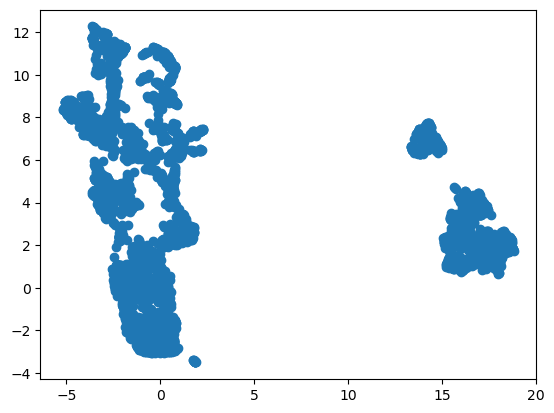

In [52]:

embedding_rf = UMAP(
  n_components=2,
  n_neighbors=10,
  metric="precomputed",
  random_state= 500009,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

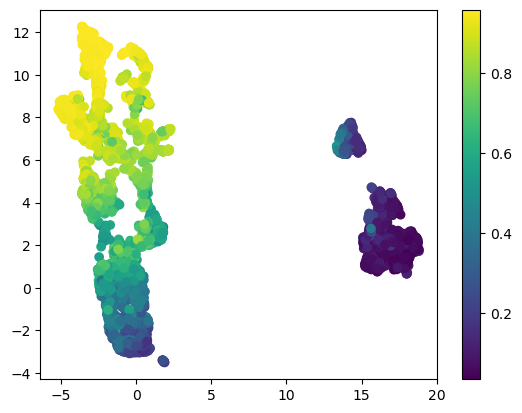

In [53]:

class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

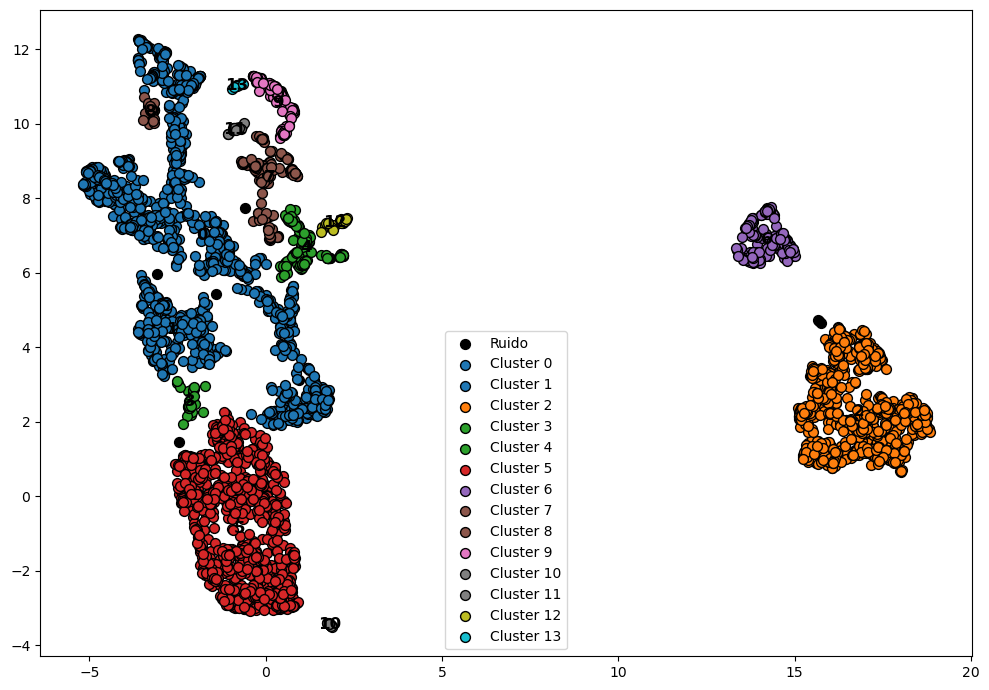

In [54]:

# Asumiendo que embedding_rf ya está definido
hdb = DBSCAN(eps=0.33)
y = hdb.fit(embedding_rf)

labels_unique = np.unique(y.labels_)
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(labels_unique)))

plt.figure(figsize=(10, 7))
for label in labels_unique:
    if label == -1:
        color = 'k'
        label_name = 'Ruido'
    else:
        color = colors[label % len(colors)]
        label_name = f'Cluster {label}'
    cluster_points = embedding_rf[y.labels_ == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=color, label=label_name, edgecolor='k', s=50)
    
    # Calcular las coordenadas medias del clúster y colocar el texto
    if label != -1:
        centroid = cluster_points.mean(axis=0)
        plt.text(centroid[0], centroid[1], str(label), fontsize=12, 
                 weight='bold', color='black', ha='center', va='center')

plt.legend()
plt.tight_layout()
plt.show()


# 1 = Naraja / 3 = Marron, 4= rosa, 5 = amarillo, 0 = celeste,

#### Análisis de los clusters

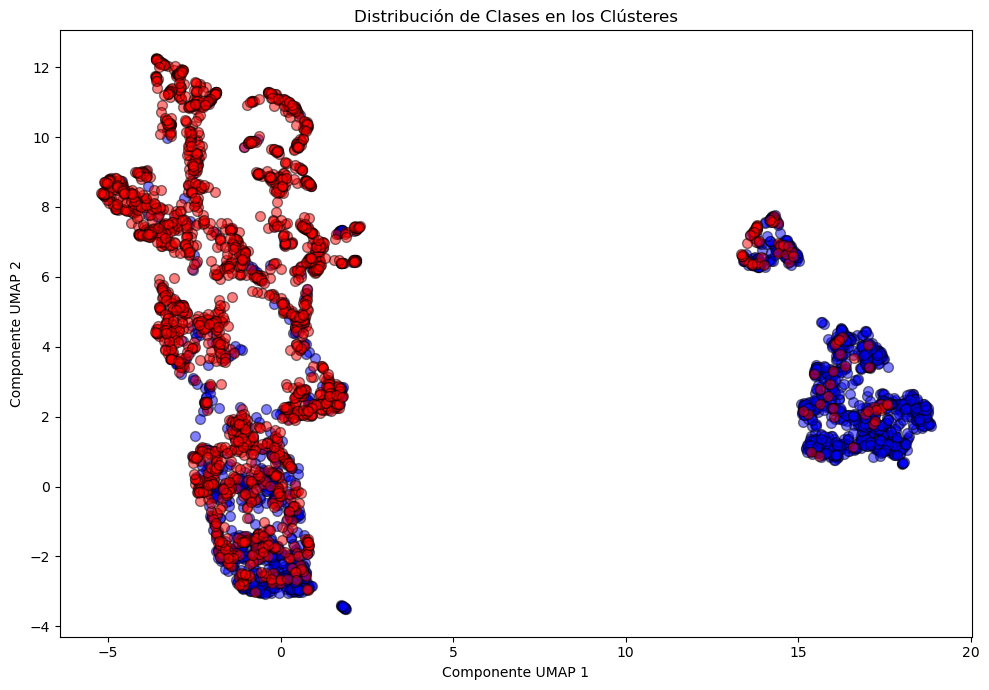

In [55]:

# Crear un mapa de colores para las clases
class_colors = {0: 'blue', 1: 'red'}
class_names = {0: 'CONTINUA', 1: 'BAJA'}

plt.figure(figsize=(10, 7))

# Obtener etiquetas de clúster únicas
labels_unique = np.unique(y.labels_)
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(labels_unique)))

for label in labels_unique:
    # Indices de los puntos en este clúster
    idx = y.labels_ == label
    # Obtener las etiquetas de clase de estos puntos
    classes_in_cluster = ytrain_rf.values[idx]
    # Colorear puntos según su clase
    for class_value in [0, 1]:
        idx_class = idx & (ytrain_rf.values == class_value)
        if np.any(idx_class):
            plt.scatter(
                embedding_rf[idx_class, 0],
                embedding_rf[idx_class, 1],
                color=class_colors[class_value],
                label=f'Clúster {label}, {class_names[class_value]}',
                edgecolor='k',
                s=50,
                alpha=0.5
            )

# Eliminar duplicados en la leyenda

plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.title('Distribución de Clases en los Clústeres')
plt.tight_layout()
plt.show()

In [56]:
pd.Series(y.labels_).value_counts()

 0     1093
 5     1053
 2      964
 1      279
 6      212
 4      151
 7      138
 9      123
 12      41
 3       34
 8       30
 11      27
 10      15
-1        8
 13       8
Name: count, dtype: int64

In [58]:

df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=500009)
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [59]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:8]:
    print(f"  - {feature}")
    

Cluster 0 vs. Resto:
  - t_saldo_total
  - mcomisiones
  - mcomisiones_otras
  - mtarjeta_visa_consumo
  - lag_consumo_total2
  - mrentabilidad
  - Visa_msaldototal
  - ctarjeta_visa_transacciones
Cluster 1 vs. Resto:
  - ctrx_quarter_dd
  - ctrx_quarter
  - mtarjeta_visa_consumo
  - ctarjeta_visa_transacciones
  - t_saldo_total
  - lag_ctrx_quarter1
  - lag_ctrx_quarter2
  - Visa_msaldopesos
Cluster 2 vs. Resto:
  - mpayroll
  - mpayroll_dd
  - cpayroll_trx
  - lag_mpayroll1
  - lag_mpayroll2
  - t_saldo_total
  - mcomisiones_mantenimiento
  - mtarjeta_visa_consumo
Cluster 3 vs. Resto:
  - intensidad_gasto_dd
  - intensidad_gasto
  - ctrx_quarter_dd
  - ctrx_quarter
  - Visa_msaldototal
  - mcuentas_saldo
  - mtarjeta_visa_consumo
  - lag_ctrx_quarter1
Cluster 4 vs. Resto:
  - mrentabilidad
  - mcuentas_saldo
  - mcomisiones
  - mcomisiones_otras
  - Visa_msaldototal
  - lag_ctrx_quarter1
  - mpasivos_margen
  - ctrx_quarter
Cluster 5 vs. Resto:
  - mpayroll
  - cpayroll_trx
  - lag_m

In [60]:
# Crear DataFrame final
Xtrain_rf_imp_df = pd.DataFrame(
    Xtrain_rf_imp,
    index=Xtrain_rf.index,
    columns=Xtrain_rf.columns
)



df_clustered = Xtrain_rf_imp_df.copy()
df_clustered['class_label'] = ytrain_rf
df_clustered['cluster'] = y.labels_

In [61]:
df_clustered.shape

(4176, 181)

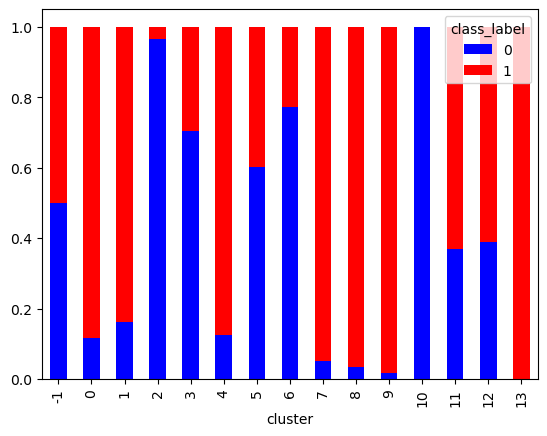

In [63]:
df_clustered.groupby('cluster')['class_label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['blue', 'red'])
clusters_importantes = ['0,1,4,7,8,9,13']


In [66]:
df_clustered.shape

(4176, 181)

In [67]:
print(df_clustered['cluster'].value_counts())


cluster
 0     1093
 5     1053
 2      964
 1      279
 6      212
 4      151
 7      138
 9      123
 12      41
 3       34
 8       30
 11      27
 10      15
-1        8
 13       8
Name: count, dtype: int64


In [68]:
df_clustered.columns

Index(['numero_de_cliente', 'active_quarter', 'cliente_vip', 'internet',
       'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen',
       ...
       'cliente_edad_dd', 'ctrx_quarter_dd', 'mactivos_margen_dd',
       'mpayroll_dd', 'intensidad_gasto_dd', 'cproductos_dd',
       'maximo_valor_columna', 'days_since_primer_registro', 'class_label',
       'cluster'],
      dtype='object', length=181)

##### Cluster 0 - t_saldo_total  

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables a analizar
variables = ['t_saldo_total', 'lag_consumo_total1', 'lag_consumo_total2' ]

for var in variables:
    g = sns.FacetGrid(df_clustered, col='cluster', height=4, col_wrap=4)
    try:
        g.map_dataframe(
            sns.histplot,
            x=var,
            hue='class_label',
            multiple='stack',
            palette={0: 'blue', 1: 'red'}
        )
    except ValueError as e:
        print(f"Error al graficar el clúster {cluster}: {e}")
        continue
    g.add_legend(title='Clase', labels=['CONTINUA', 'BAJA + 2'])
    g.set_titles('Clúster {col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribución de {var} por Clúster y Clase')
    plt.show()

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


KeyboardInterrupt: 

In [71]:

# Variables a analizar
variables = ['t_saldo_total', 'lag_consumo_total1', 'lag_consumo_total2']

# Obtener los clústeres únicos
clusters = df_clustered['cluster'].unique()

for var in variables:
    # Crear subplots
    fig = make_subplots(rows=1, cols=len(clusters), subplot_titles=[f'Clúster {c}' for c in clusters])

    for i, cluster in enumerate(clusters):
        # Filtrar datos por clúster
        cluster_data = df_clustered[df_clustered['cluster'] == cluster]

        # Crear histograma
        hist = px.histogram(
            cluster_data,
            x=var,
            color='class_label',
            color_discrete_map={0: 'blue', 1: 'red'},
            barmode='stack'
        )

        # Añadir histograma al subplot
        for trace in hist['data']:
            fig.add_trace(trace, row=1, col=i+1)

    # Actualizar el layout
    fig.update_layout(
        title_text=f'Distribución de {var} por Clúster y Clase',
        showlegend=True,
        height=400,
        width=300 * len(clusters)
    )

    # Mostrar el gráfico
    fig.show()

In [72]:
df_clustered['mpayroll']

15499          0.00
15603          0.00
15607          0.00
15842          0.00
15861      21159.07
            ...    
857796         0.00
857845         0.00
857882     26821.81
857888    130347.27
857983         0.00
Name: mpayroll, Length: 4176, dtype: float64

In [73]:
# ctrx_quarter  - mautoservicio  - mpayroll  - mtransferencias_emitidas  - ctarjeta_debito_transacciones

# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    
    cliente_edad = ('cliente_edad', 'mean'),
    ctrx_quarter = ('ctrx_quarter', 'mean'),
    Saldo_tarjeta_antes_baja=('t_saldo_total', 'mean'),
    consumo_total_mes_anterior=('lag_consumo_total1', 'mean'),
    consumo_total_mes_anterior2=('lag_consumo_total2', 'mean'), 
    Sueldo_max=('mpayroll', 'max'),
    Sueldo_mean=('mpayroll', 'mean'),
    Sueldo_max_mes_anterior=('lag_mpayroll1', 'mean'),
    Sueldo_max_mes_2_anteriores=('lag_mpayroll2', 'mean'),
    Internet = ('internet', 'mean'),
    cmobile_app_trx = ('cmobile_app_trx', 'mean'),
    Debito = ('mautoservicio', 'mean'),
    cpagodeservicios = ('cpagodeservicios','mean'),
    cextraccion_autoservicio = ('cextraccion_autoservicio','mean'),
    ccheques_emitidos = ('ccheques_emitidos','mean'),
    Master_mconsumototal = ('Master_mconsumototal','mean'),
    Master_mlimitecompra = ('Master_mlimitecompra','mean'),
).reset_index()

# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

In [74]:
df_train['cmobile_app_trx'].mean()

0.7174814093646698

In [75]:
df_cluster_1 = df_clustered[(df_clustered['cluster'] == 1) | (df_clustered['cluster'] == 2)]

px.scatter(df_cluster_1, x='t_saldo_total', y='mpayroll', color='cluster', symbol='class_label', opacity=0.3, title='Distribución de Saldo y Consumo por Clúster y Clase')

In [76]:
df_clustered.columns

Index(['numero_de_cliente', 'active_quarter', 'cliente_vip', 'internet',
       'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen',
       ...
       'cliente_edad_dd', 'ctrx_quarter_dd', 'mactivos_margen_dd',
       'mpayroll_dd', 'intensidad_gasto_dd', 'cproductos_dd',
       'maximo_valor_columna', 'days_since_primer_registro', 'class_label',
       'cluster'],
      dtype='object', length=181)

##### Cluster 1 - ctrx quarter

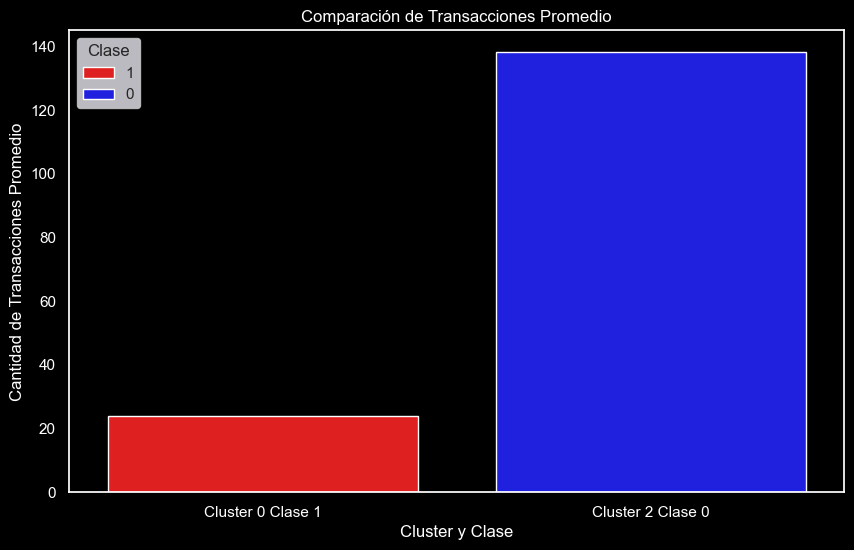

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Filtrar el DataFrame para obtener los datos necesarios
df_cluster_0_class_1 = df_clustered[(df_clustered['cluster'] == 0) & (df_clustered['class_label'] == 1)]
df_cluster_2_class_0 = df_clustered[(df_clustered['cluster'] == 2) & (df_clustered['class_label'] == 0)]

# Calcular la cantidad de transacciones promedio
mean_trans_cluster_0_class_1 = df_cluster_0_class_1['ctrx_quarter'].mean()
mean_trans_cluster_2_class_0 = df_cluster_2_class_0['ctrx_quarter'].mean()

# Crear un DataFrame para el gráfico
data = {
    'Cluster y Clase': ['Cluster 0 Clase 1', 'Cluster 2 Clase 0'],
    'Cantidad de Transacciones Promedio': [mean_trans_cluster_0_class_1, mean_trans_cluster_2_class_0],
    'Clase': ['1', '0']  # Añadir una columna para la clase
}
df_plot = pd.DataFrame(data)

# Configurar el estilo de Seaborn
sns.set(style="dark")

# Crear la figura y el eje
plt.figure(figsize=(10, 6))

# Gráfico de barras
ax = sns.barplot(
    x='Cluster y Clase', 
    y='Cantidad de Transacciones Promedio', 
    data=df_plot,
    palette={'1': 'red', '0': 'blue'},  # Asignar colores a las clases
    hue='Clase'  # Usar la columna 'Clase' para asignar los colores
)

# Ajustar el color de las etiquetas y el título
ax.set_title('Comparación de Transacciones Promedio', color='white')
ax.set_xlabel('Cluster y Clase', color='white')
ax.set_ylabel('Cantidad de Transacciones Promedio', color='white')
ax.tick_params(colors='white')

# Cambiar el color del fondo de la figura y del eje
ax.set_facecolor('black')
plt.gcf().set_facecolor('black')

# Mostrar el gráfico
plt.show()

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



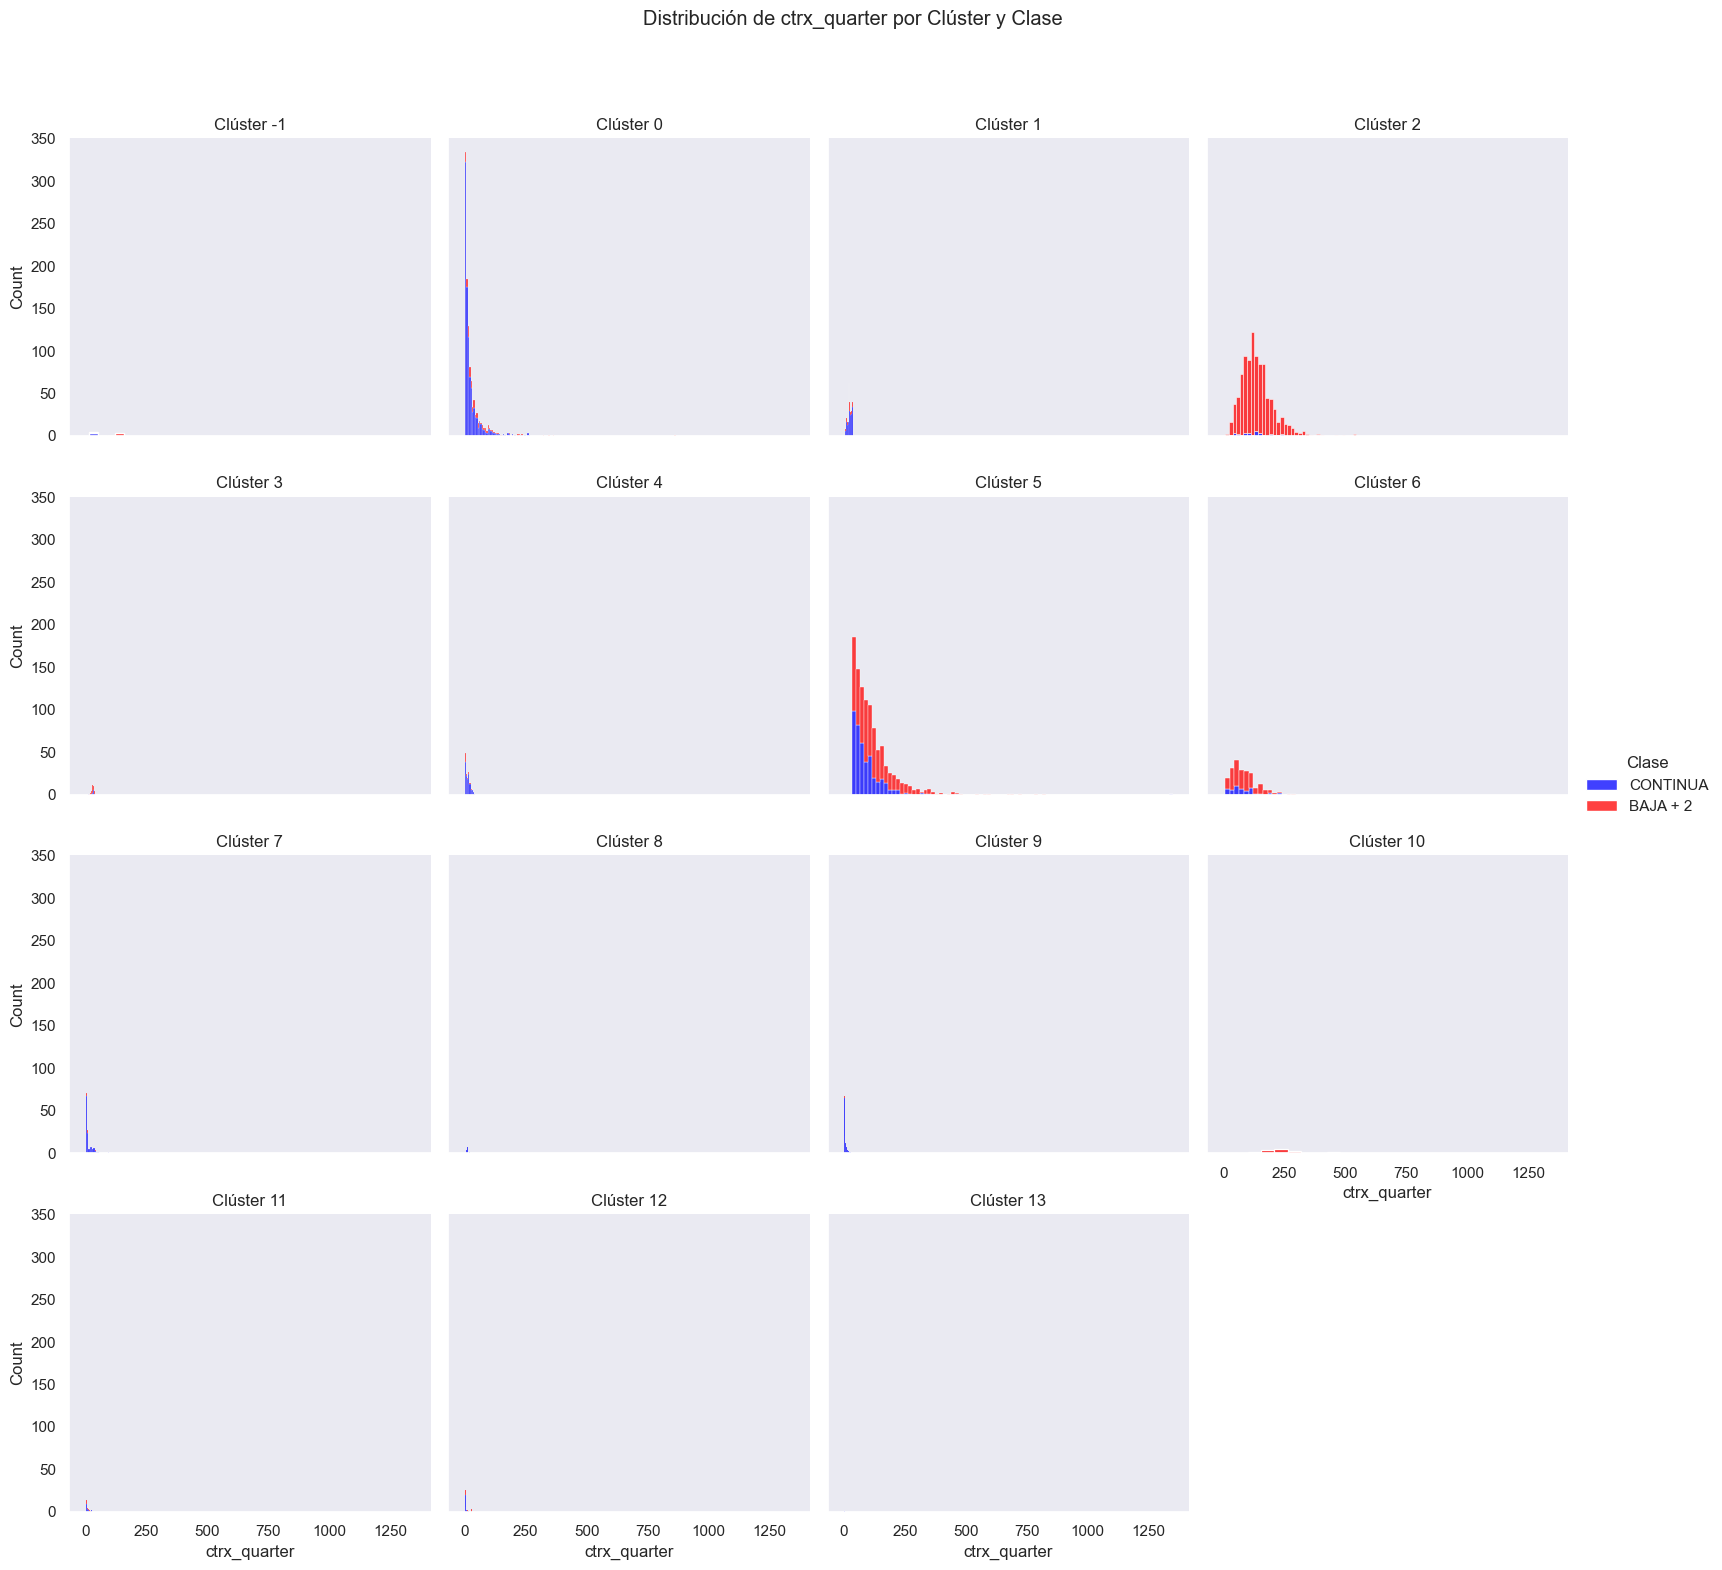

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



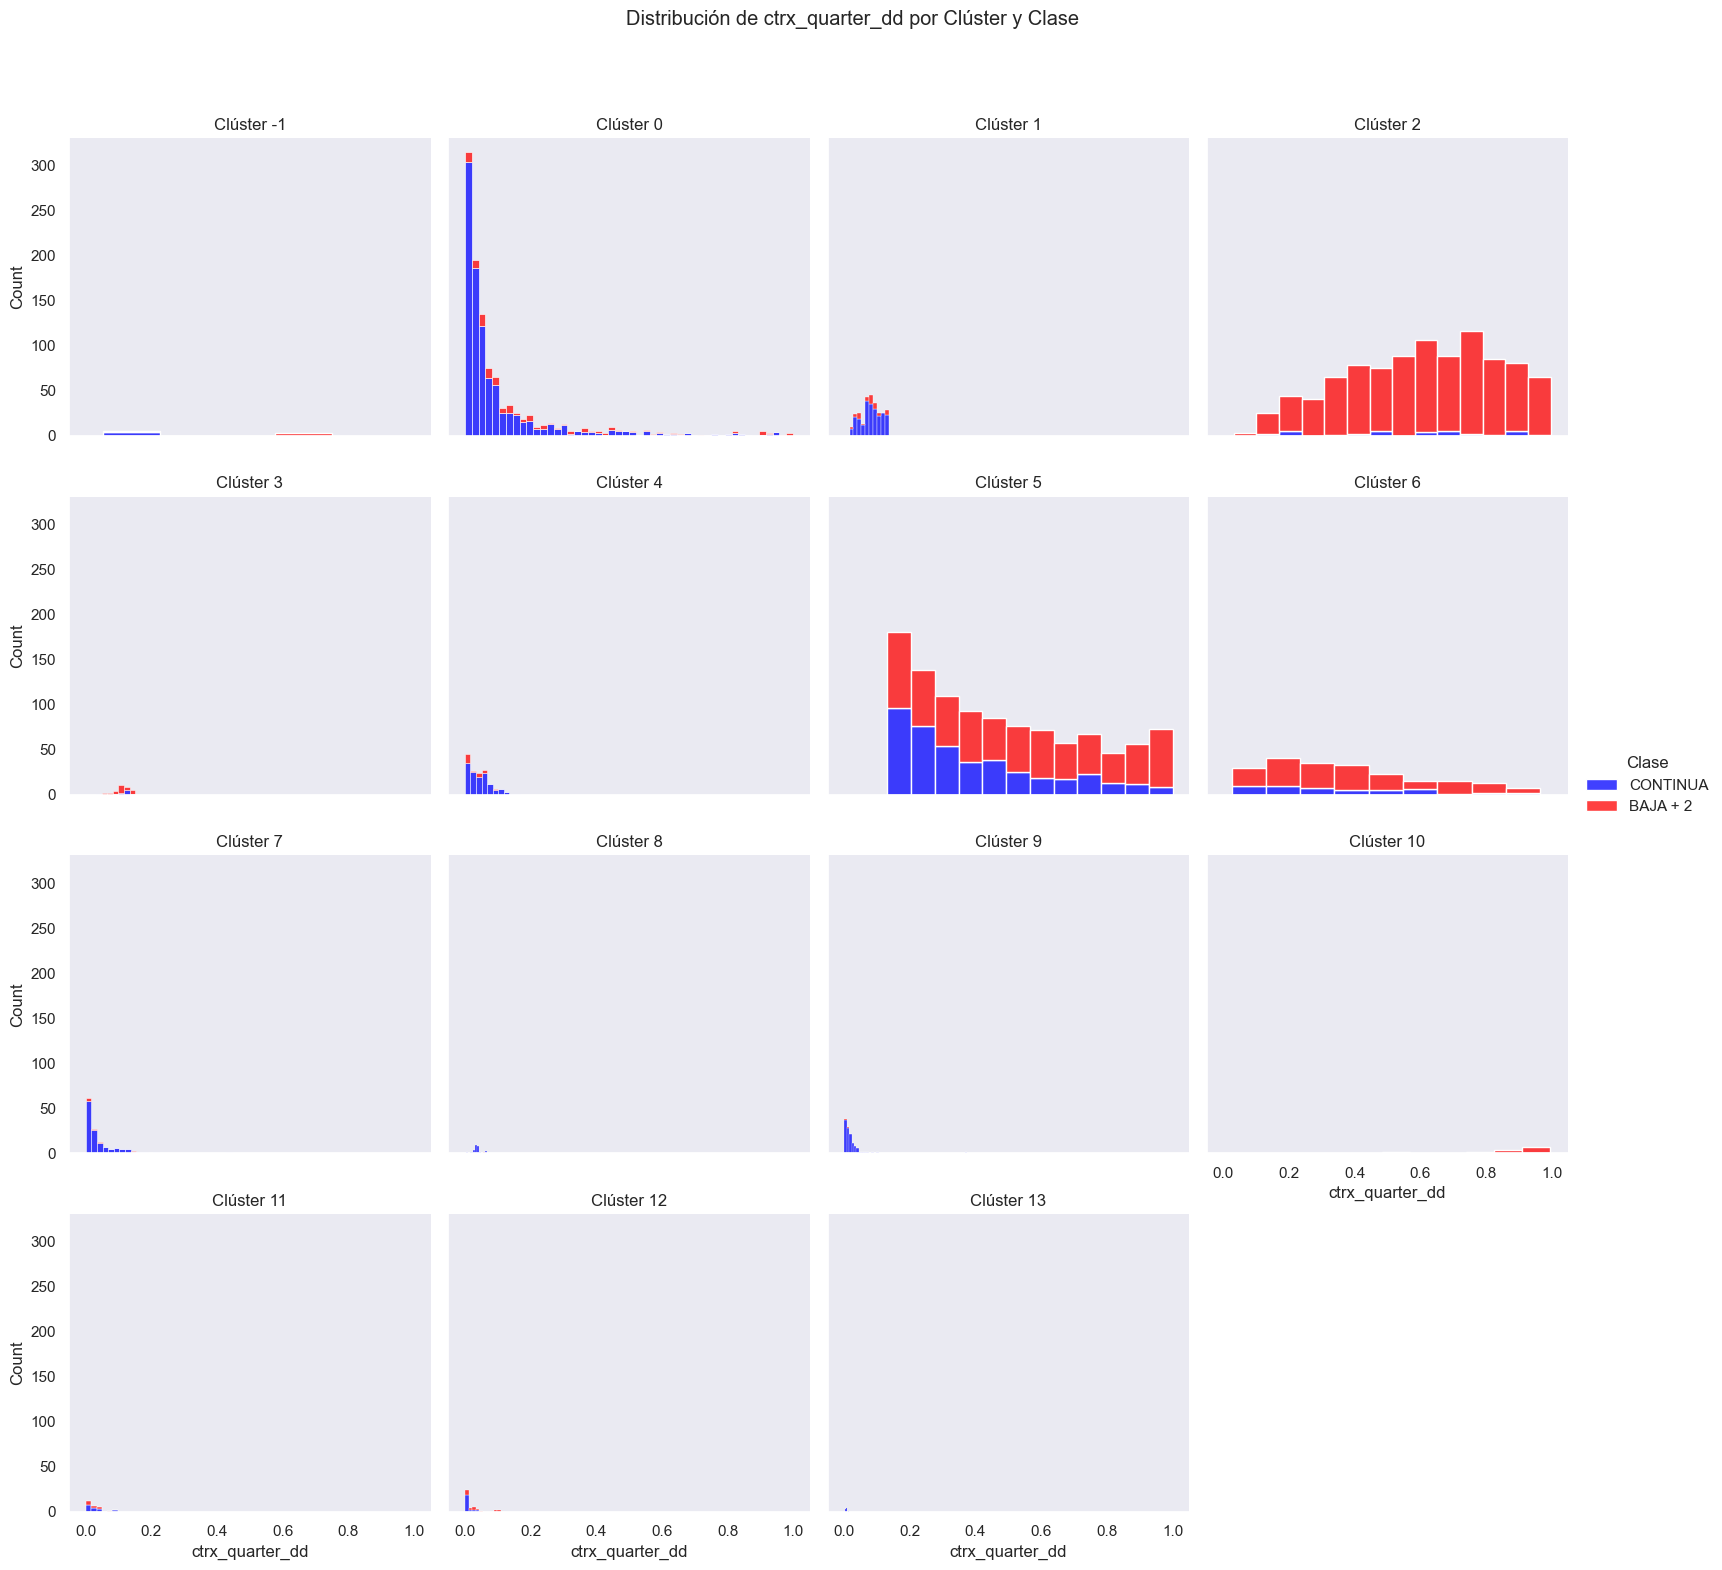

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



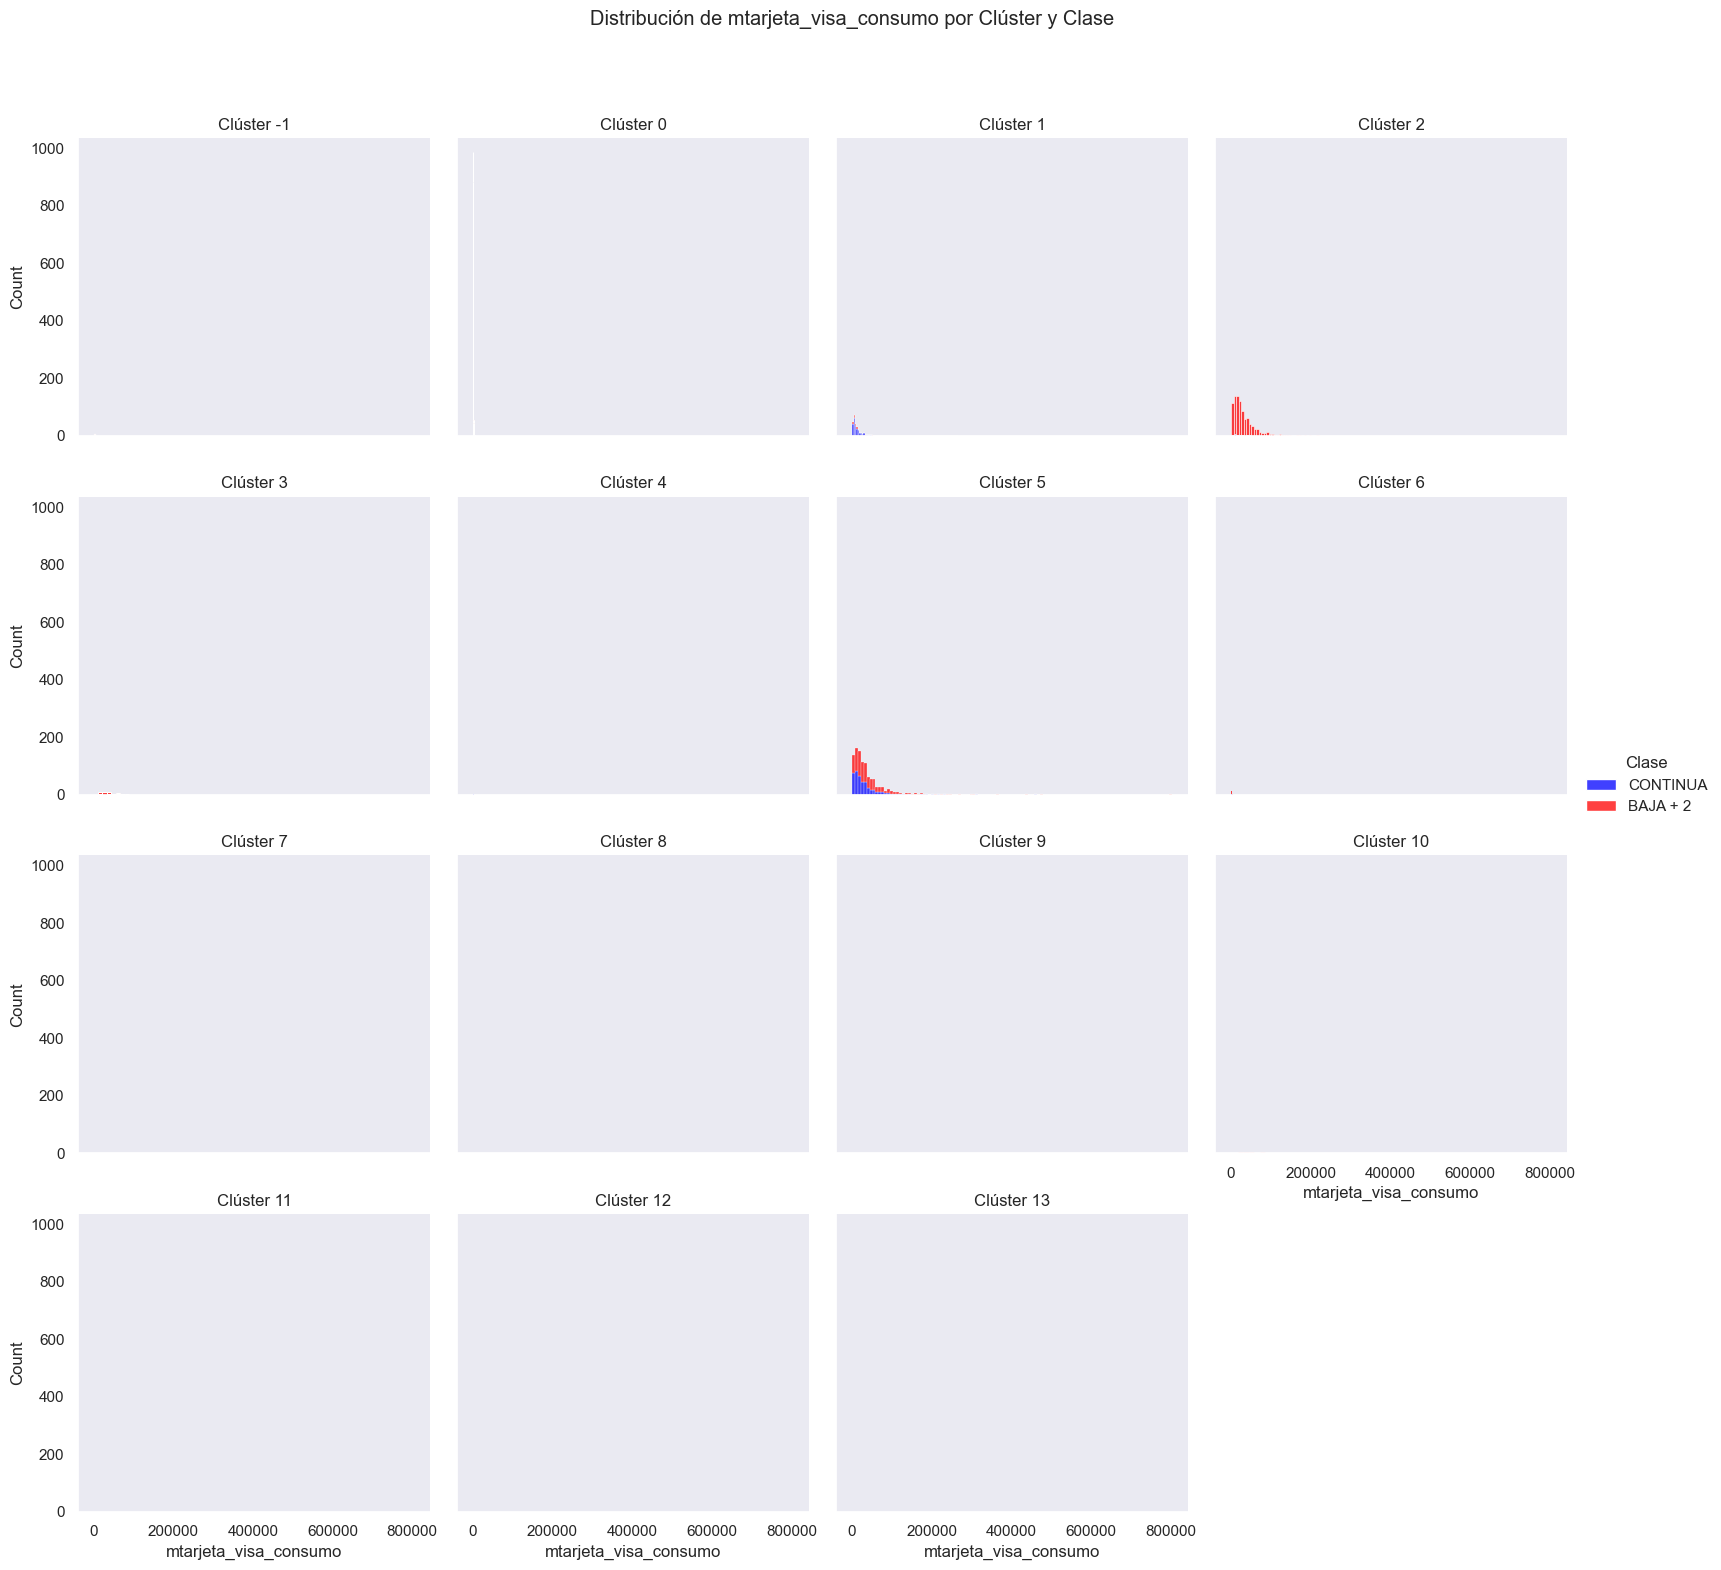

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



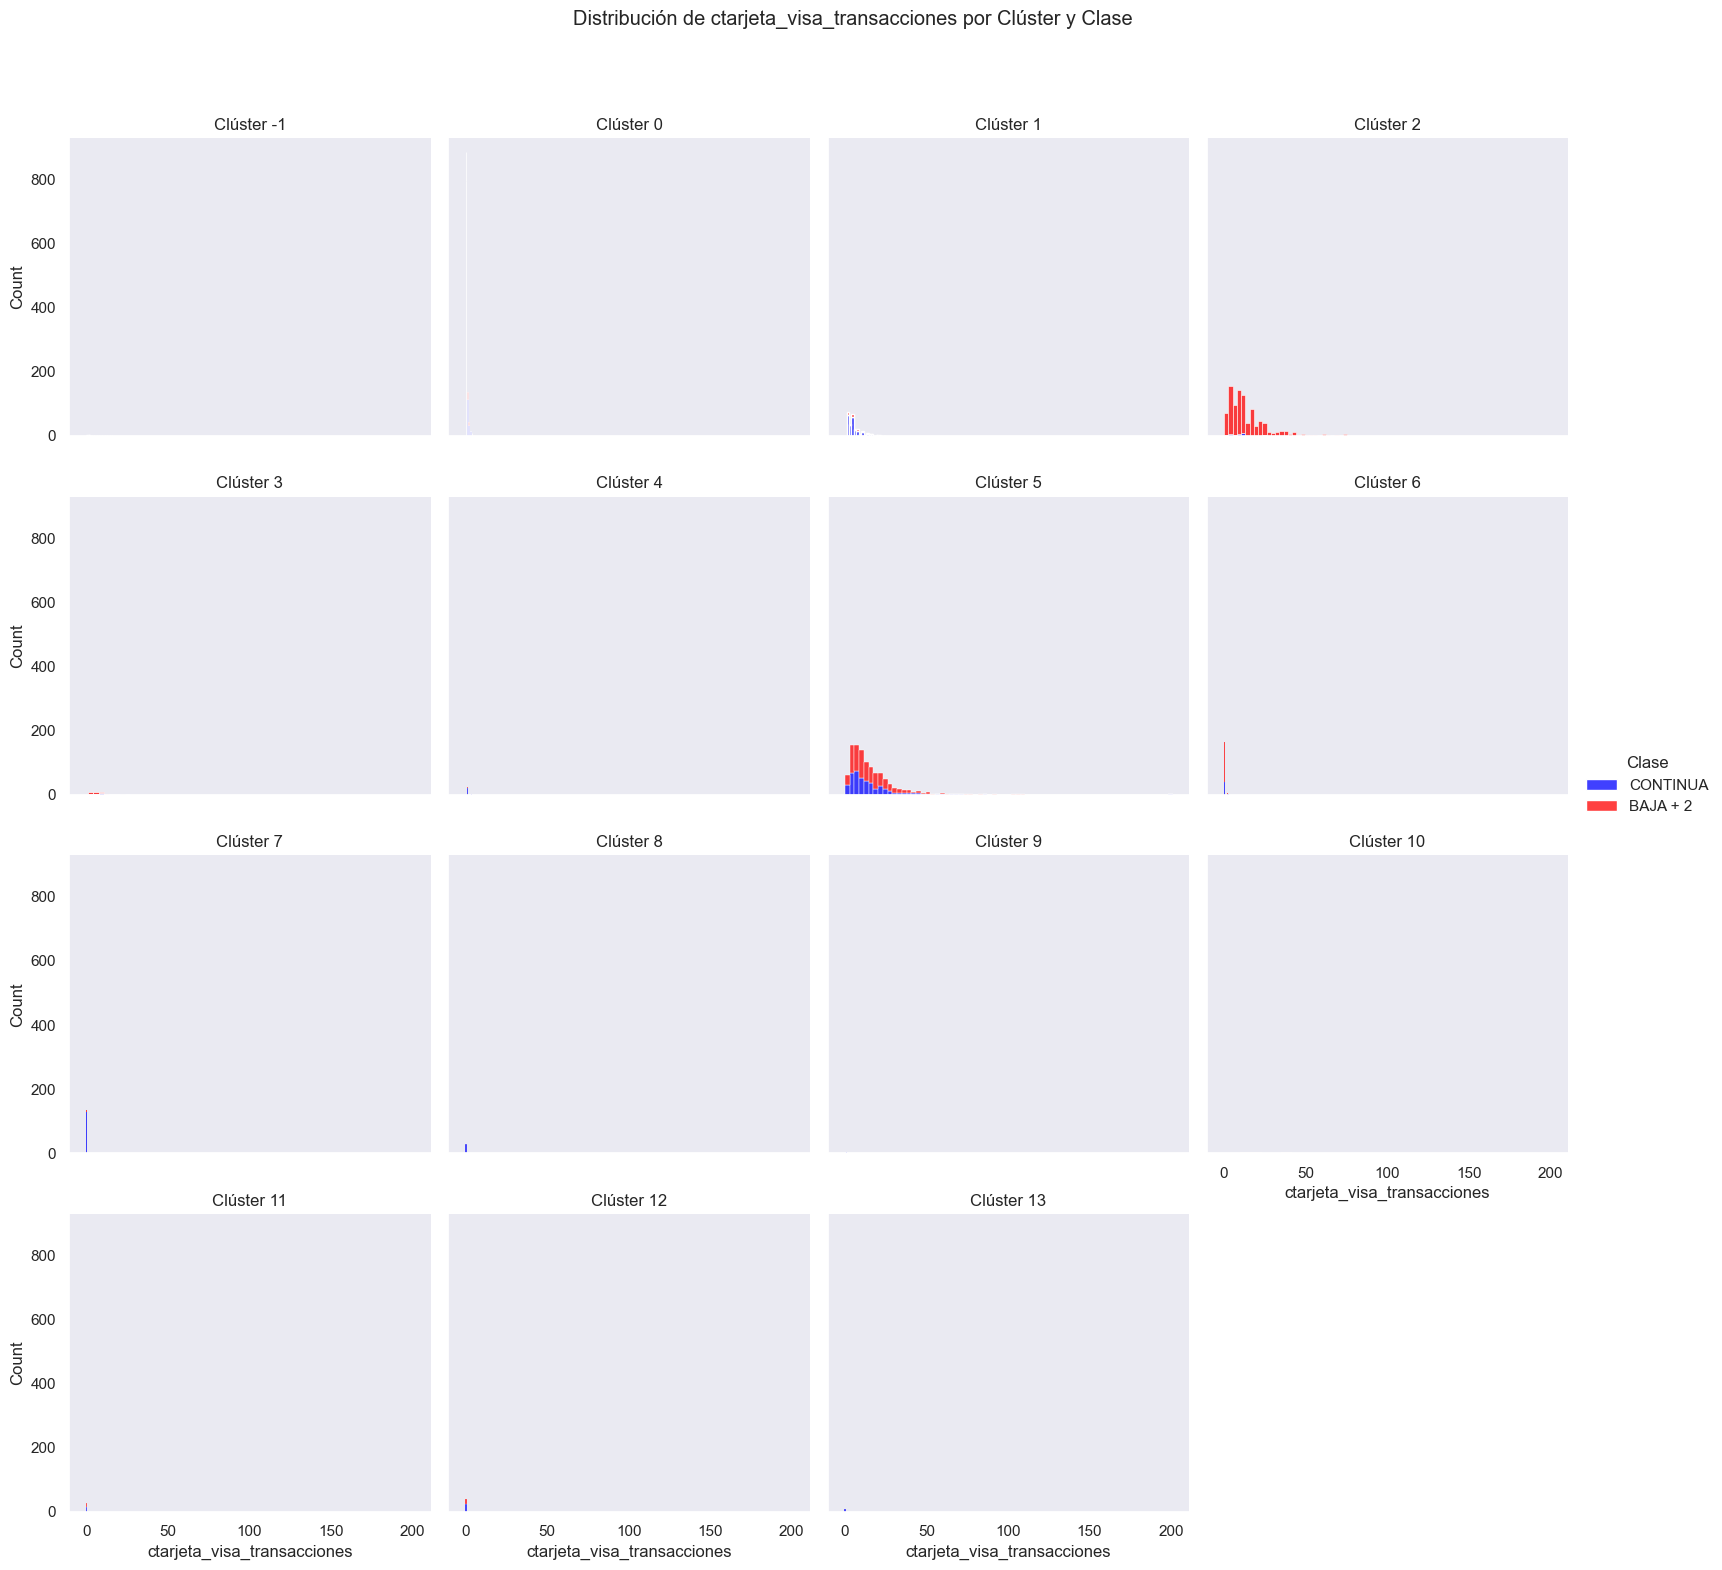

In [79]:

variables = ['ctrx_quarter', 'ctrx_quarter_dd', 'mtarjeta_visa_consumo', 'ctarjeta_visa_transacciones' ]

for var in variables:
    g = sns.FacetGrid(df_clustered, col='cluster', height=4, col_wrap=4)
    try:
        g.map_dataframe(
            sns.histplot,
            x=var,
            hue='class_label',
            multiple='stack',
            palette={0: 'red', 1: 'blue'}
        )
    except ValueError as e:
        print(f"Error al graficar el clúster {cluster}: {e}")
        continue
    g.add_legend(title='Clase', labels=['CONTINUA', 'BAJA + 2'])
    g.set_titles('Clúster {col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribución de {var} por Clúster y Clase')
    plt.show()

In [80]:

# Variables a analizar
variables = ['ctrx_quarter', 'ctrx_quarter_dd', 'mtarjeta_visa_consumo', 'ctarjeta_visa_transacciones' ]

# Obtener los clústeres únicos
clusters = df_clustered['cluster'].unique()

for var in variables:
    # Crear subplots
    fig = make_subplots(rows=1, cols=len(clusters), subplot_titles=[f'Clúster {c}' for c in clusters])

    for i, cluster in enumerate(clusters):
        # Filtrar datos por clúster
        cluster_data = df_clustered[df_clustered['cluster'] == cluster]

        # Crear histograma
        hist = px.histogram(
            cluster_data,
            x=var,
            color='class_label',
            color_discrete_map={0: 'blue', 1: 'red'},
            barmode='stack'
        )

        # Añadir histograma al subplot
        for trace in hist['data']:
            fig.add_trace(trace, row=1, col=i+1)

    # Actualizar el layout
    fig.update_layout(
        title_text=f'Distribución de {var} por Clúster y Clase',
        showlegend=True,
        height=400,
        width=300 * len(clusters)
    )

    # Mostrar el gráfico
    fig.show()

In [81]:
df_clustered['lag_ctrx_quarter1']

15499      32.0
15603      14.0
15607       8.0
15842      21.0
15861      36.0
          ...  
857796      6.0
857845     11.0
857882     41.0
857888    118.0
857983     65.0
Name: lag_ctrx_quarter1, Length: 4176, dtype: float64

In [82]:
# ctrx_quarter  - mautoservicio  - mpayroll  - mtransferencias_emitidas  - ctarjeta_debito_transacciones
variables = ['ctrx_quarter', 'ctrx_quarter_dd', 'mtarjeta_visa_consumo', 'ctarjeta_visa_transacciones' ]
# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    cantidad_transacciones=('ctrx_quarter', 'mean'),
    cantidad_transacciones_1=('lag_ctrx_quarter1', 'mean'),
    cantidad_transacciones_2=('lag_ctrx_quarter2', 'mean'), 
    transacciones_tarjeta_visa_promedio=('ctarjeta_visa_transacciones', 'mean'),
    transacciones_tarjeta_master_promedio=('ctarjeta_master_transacciones', 'mean'),
    t_consumo_total = ('t_consumo_total', 'mean'),
    t_consumo_total_1 = ('lag_consumo_total1', 'mean'),
    t_consumo_total_2 = ('lag_consumo_total2', 'mean'),
    Sueldo_max=('mpayroll', 'max'),
    Sueldo_max_mes_anterior=('mtarjeta_visa_consumo', 'max')
      # Asegúrate de que el nombre de la columna sea correcto
).reset_index()

# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

In [84]:

# Cluster 4 vs. Resto:
#   - mrentabilidad
#   - mcuentas_saldo
#   - mcomisiones
#   - mcomisiones_otras
#   - Visa_msaldototal
#   - lag_ctrx_quarter1
#   - mpasivos_margen
#   - ctrx_quarter

# ctrx_quarter  - mautoservicio  - mpayroll  - mtransferencias_emitidas  - ctarjeta_debito_transacciones
variables = ['ctrx_quarter', 'ctrx_quarter_dd', 'mtarjeta_visa_consumo', 'ctarjeta_visa_transacciones' ]
# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    cantidad_transacciones=('ctrx_quarter', 'mean'),
    cantidad_transacciones_1=('lag_ctrx_quarter1', 'mean'),
    cantidad_transacciones_2=('lag_ctrx_quarter2', 'mean'), 
    transacciones_tarjeta_promedio=('ctarjeta_visa_transacciones', 'max'),
    Sueldo_max=('mpayroll', 'max'),
    Sueldo_max_mes_anterior=('mtarjeta_visa_consumo', 'max')
      # Asegúrate de que el nombre de la columna sea correcto
).reset_index()

# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

##### Cluster 4 - mrentabilidad

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



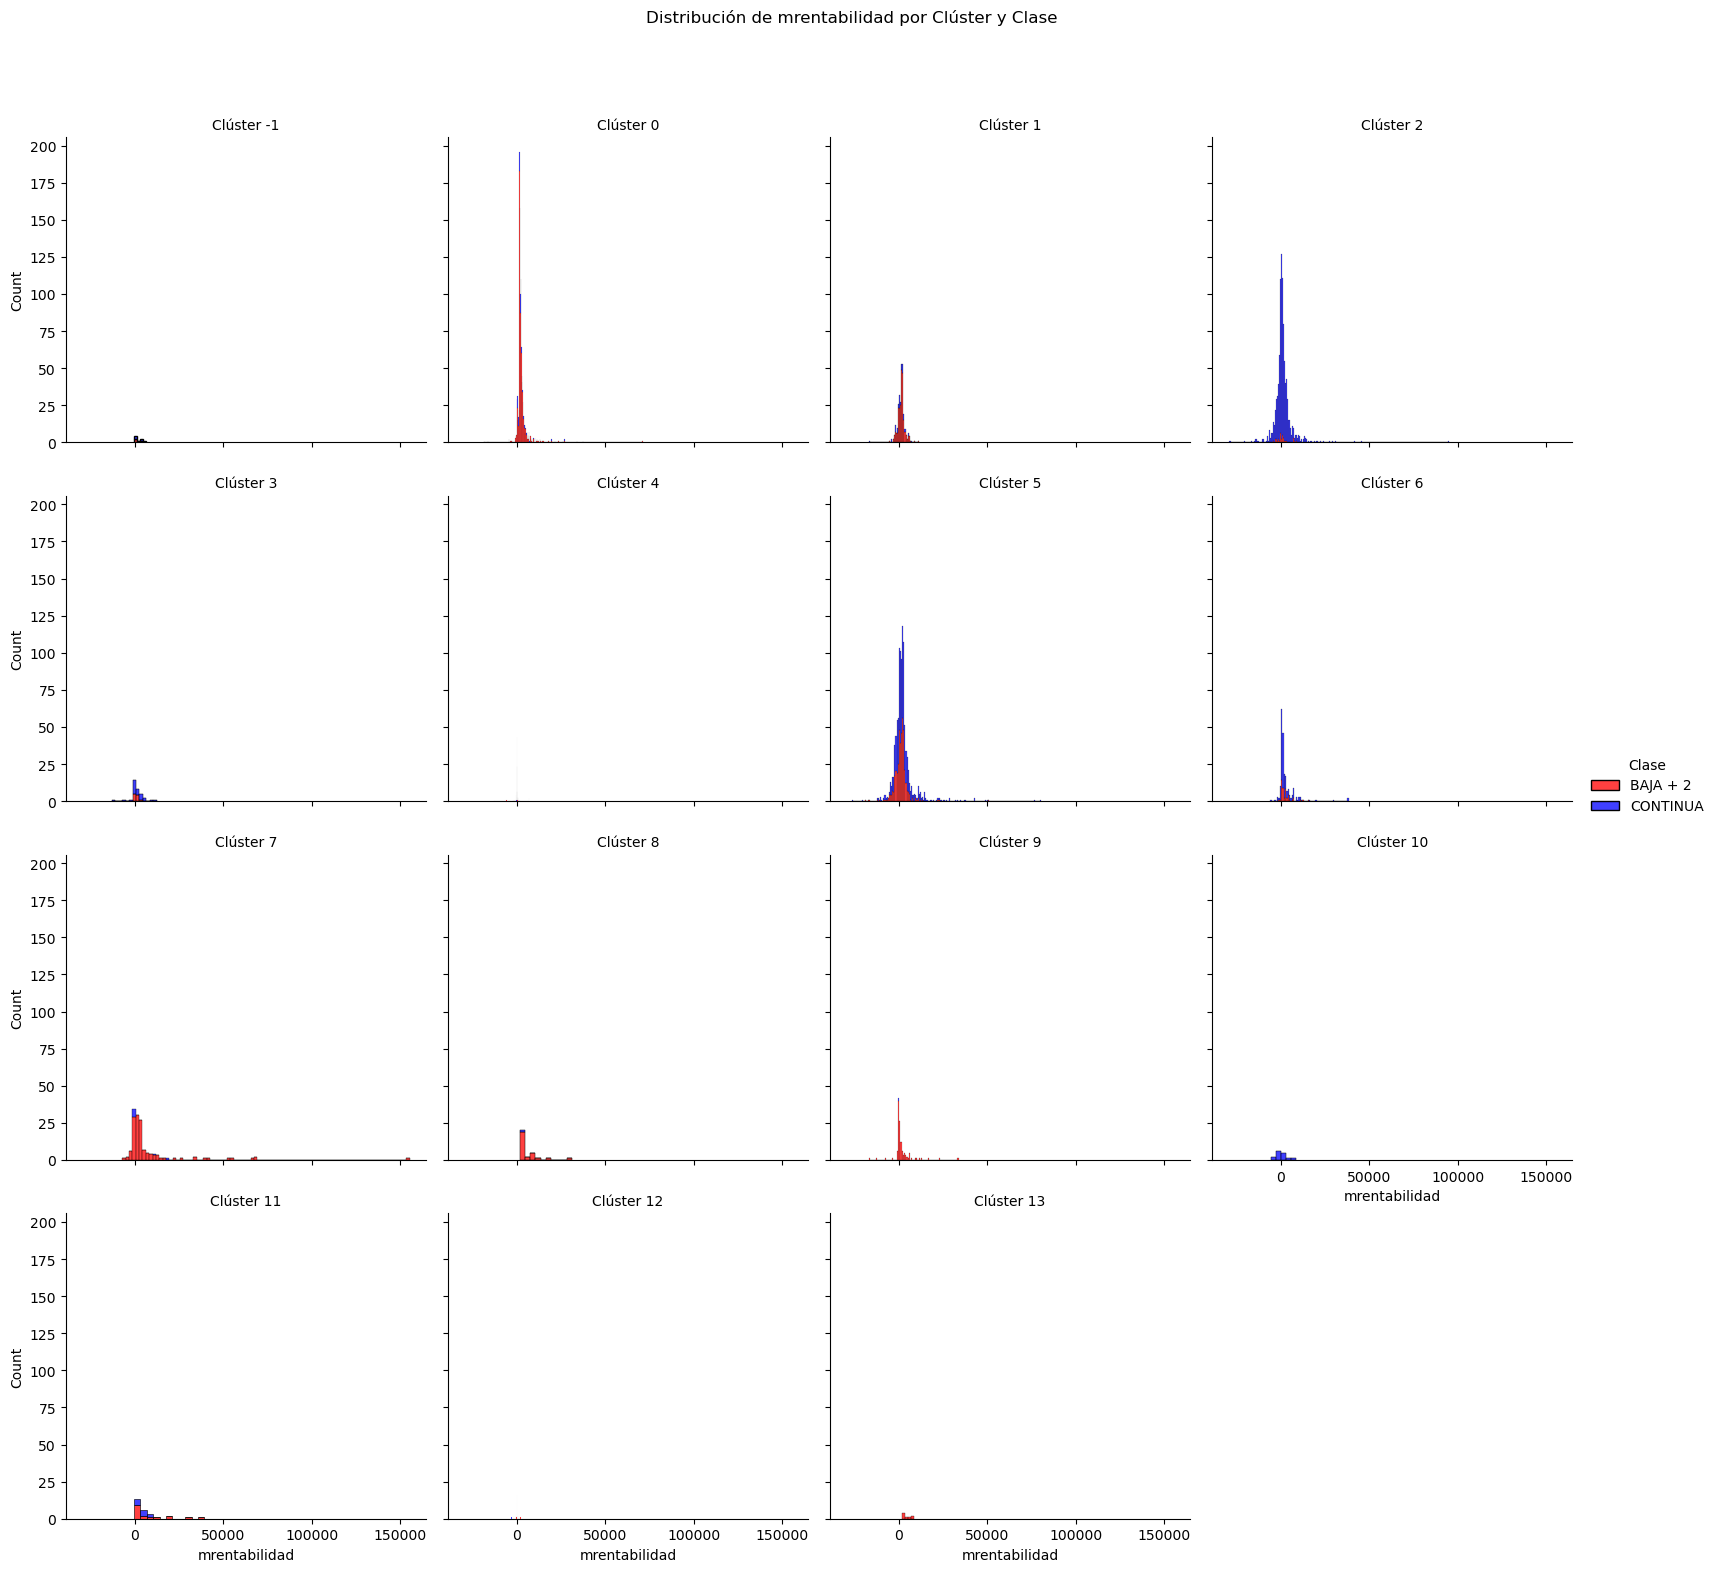

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



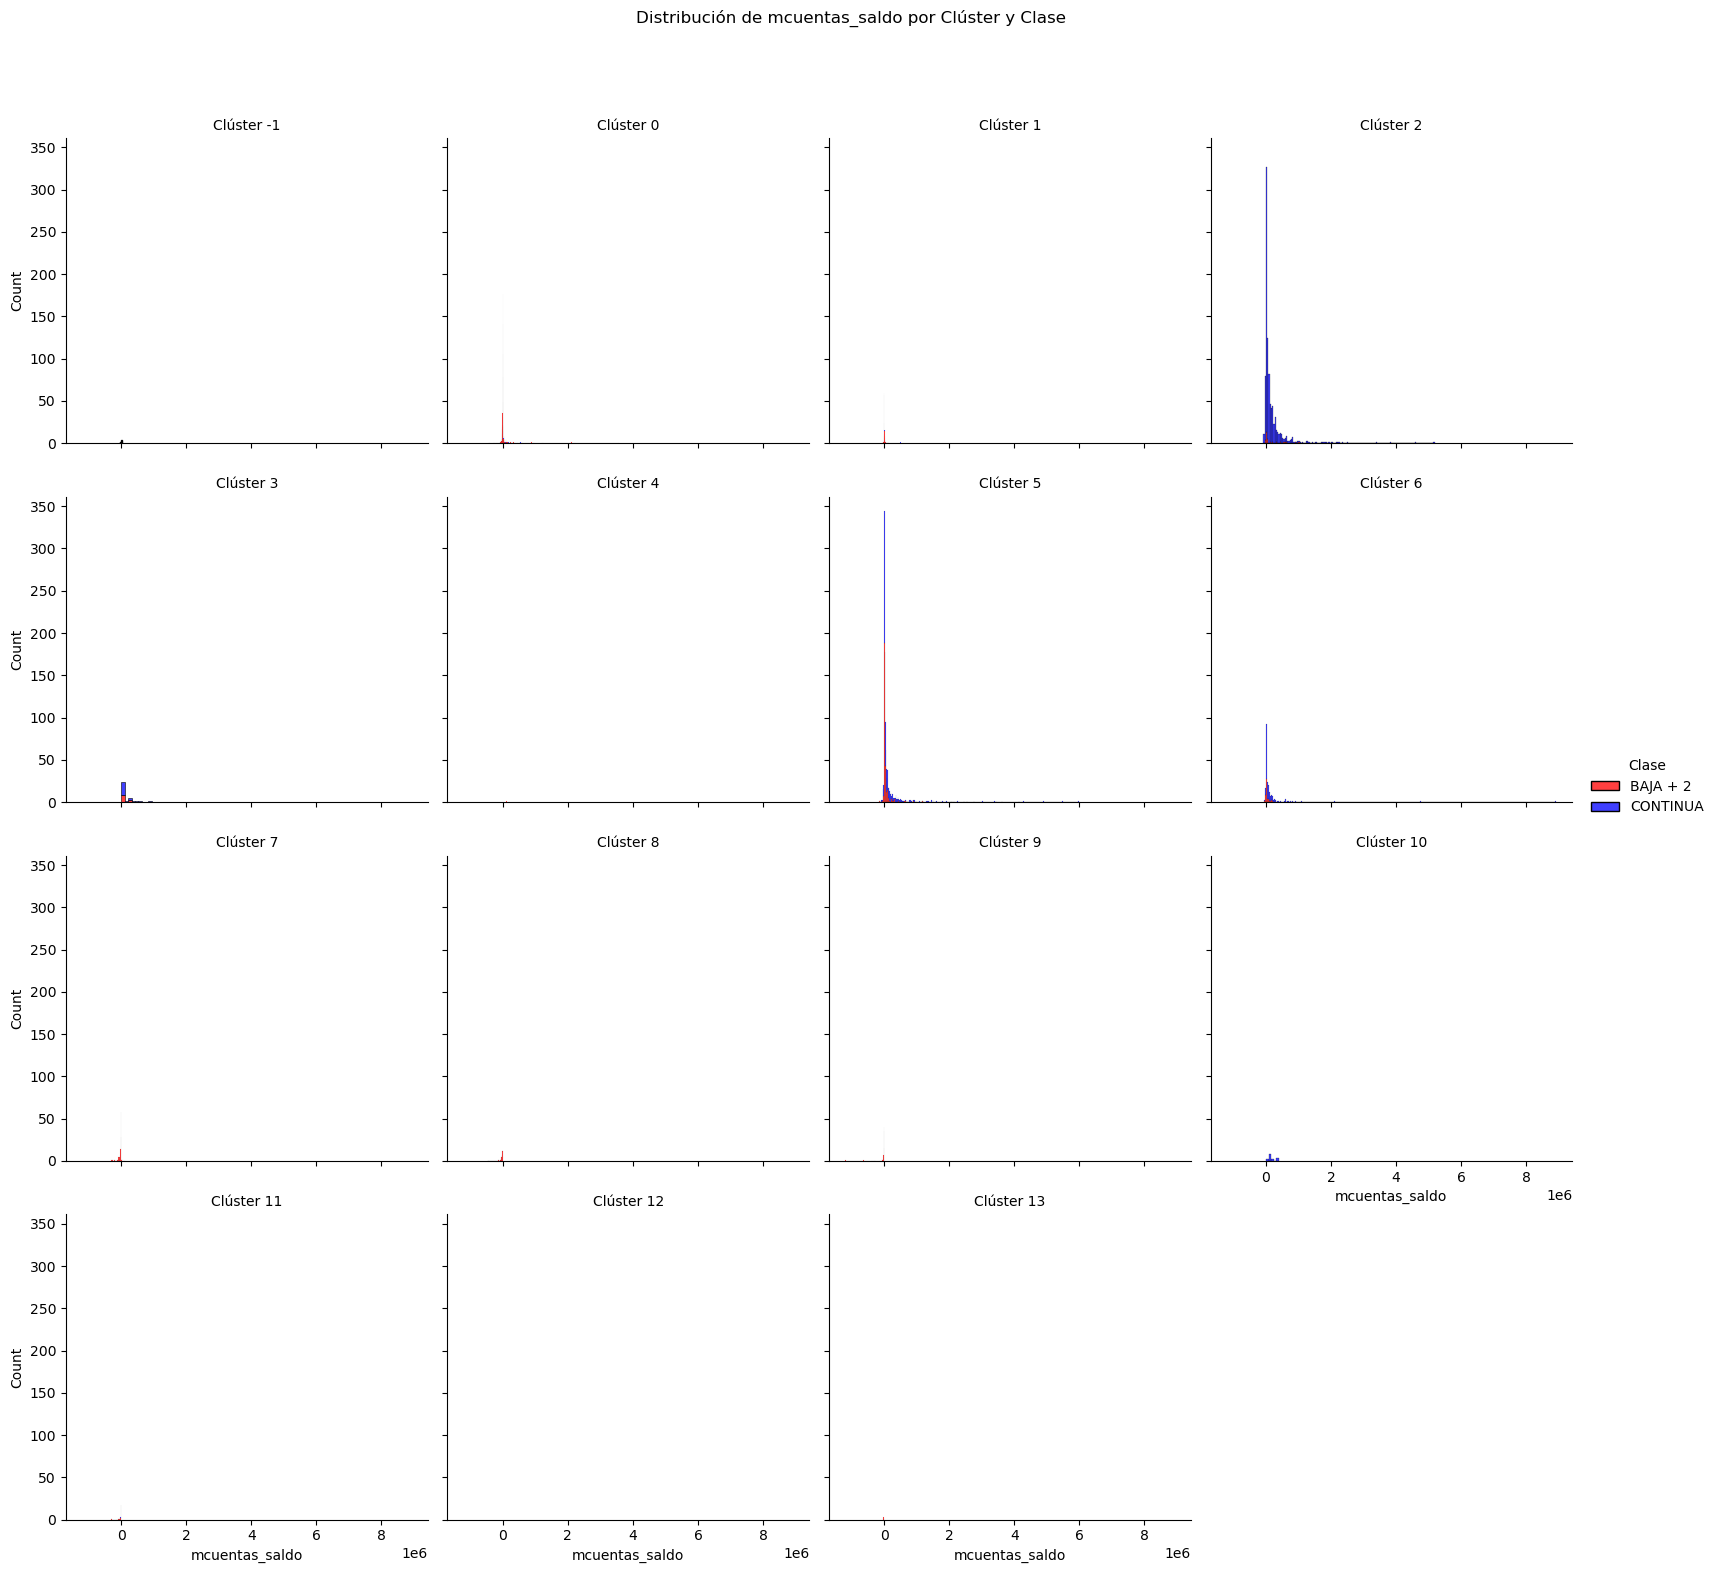

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



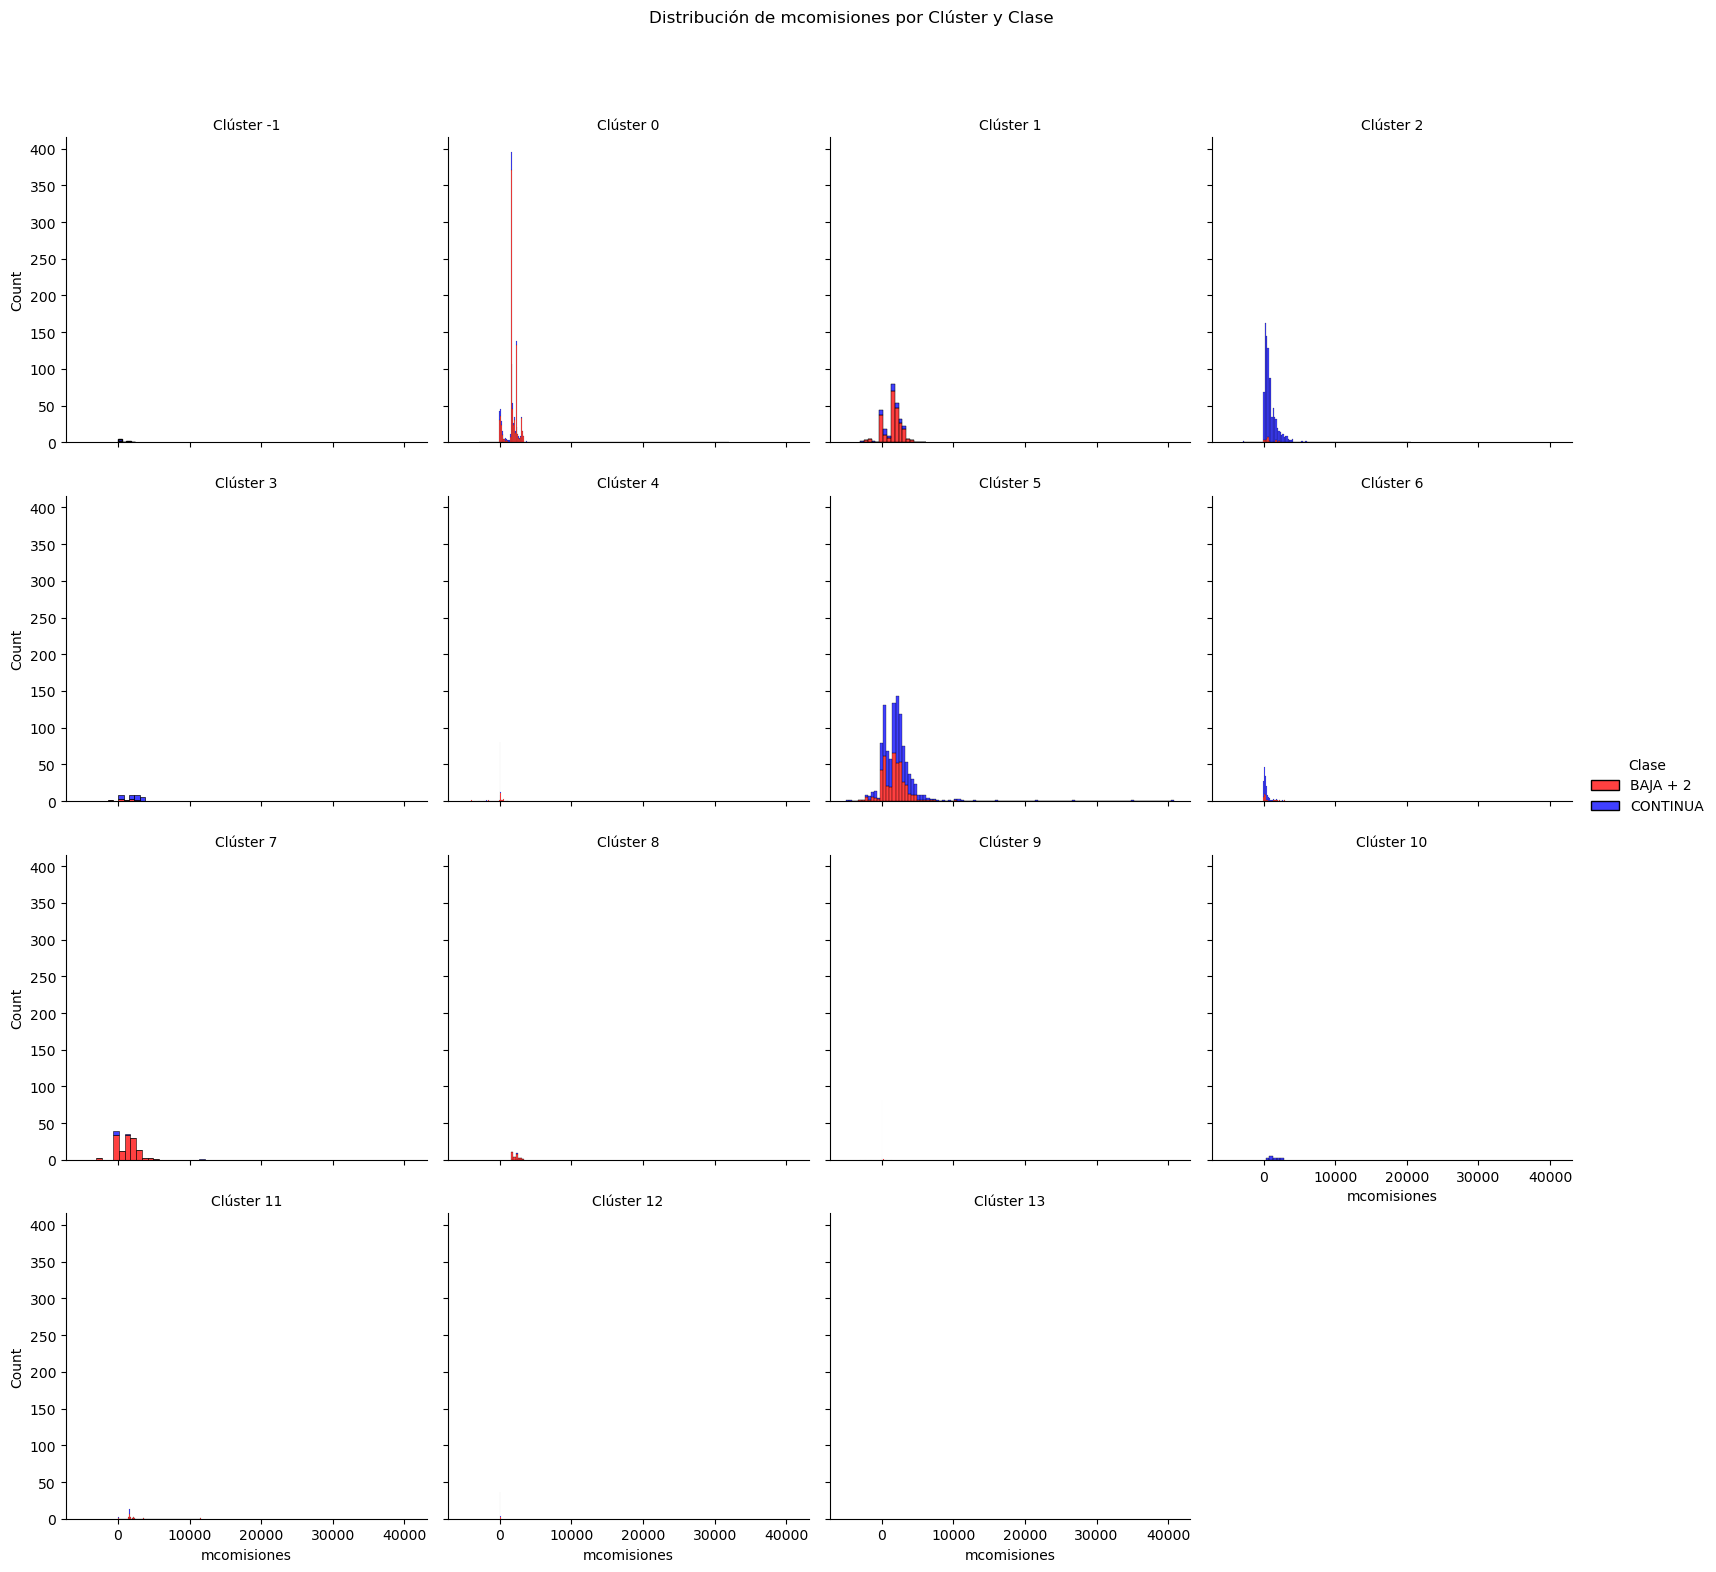

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



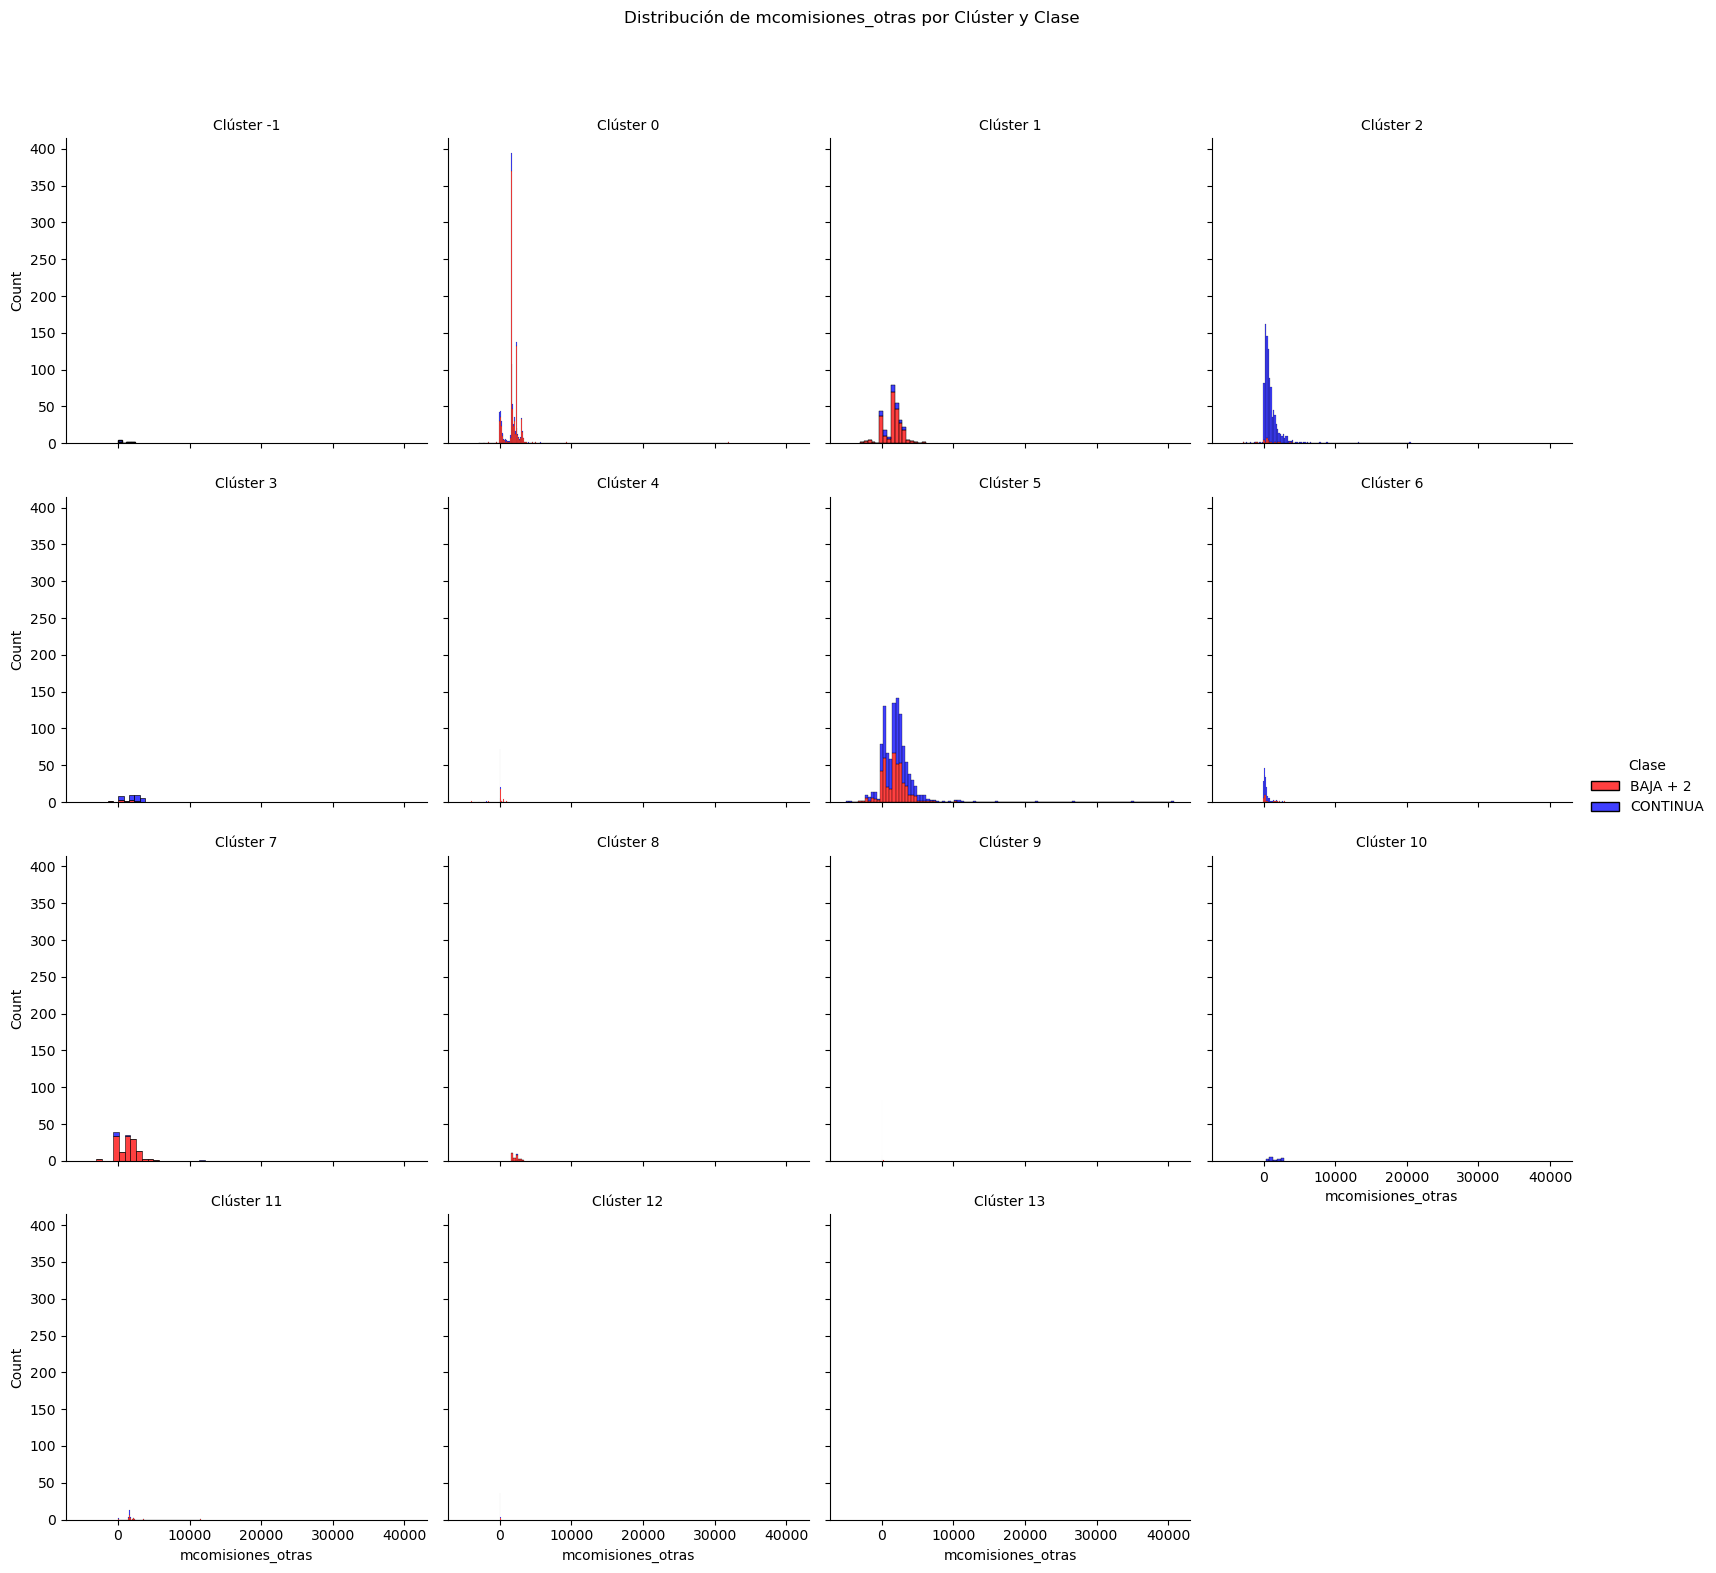

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



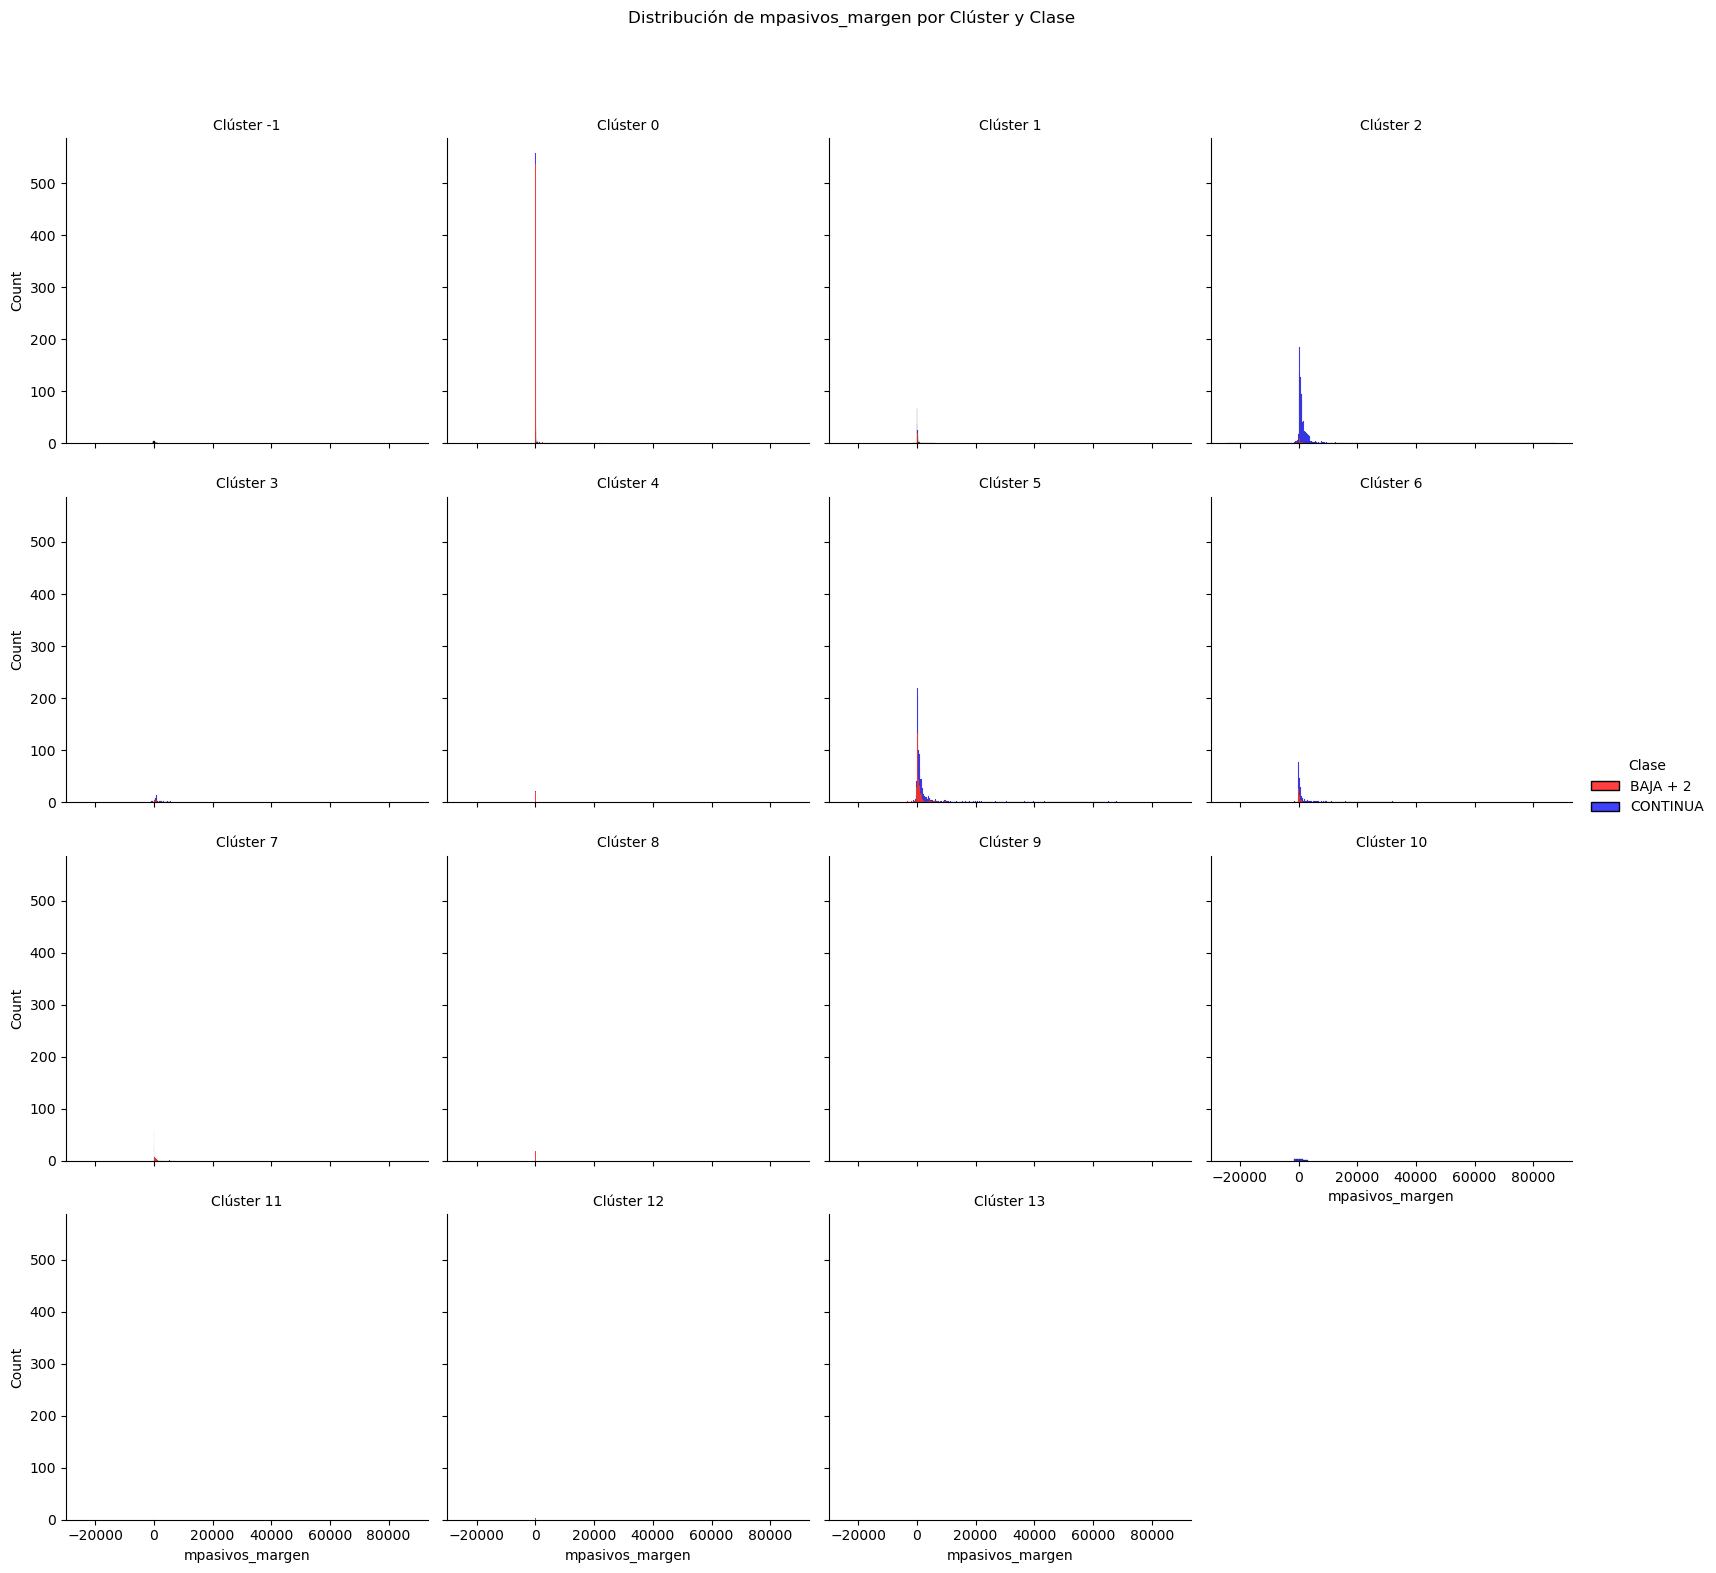

In [81]:


# Cluster 4 vs. Resto:
#   - mrentabilidad
#   - mcuentas_saldo
#   - mcomisiones
#   - mcomisiones_otras
#   - Visa_msaldototal
#   - lag_ctrx_quarter1
#   - mpasivos_margen
#   - ctrx_quarter


variables = ['mrentabilidad', 'mcuentas_saldo', 'mcomisiones', 'mcomisiones_otras', 'mpasivos_margen' ]

for var in variables:
    g = sns.FacetGrid(df_clustered, col='cluster', height=4, col_wrap=4)
    try:
        g.map_dataframe(
            sns.histplot,
            x=var,
            hue='class_label',
            multiple='stack',
            palette={0: 'blue', 1: 'red'}
        )
    except ValueError as e:
        print(f"Error al graficar el clúster {cluster}: {e}")
        continue
    g.add_legend(title='Clase', labels=['BAJA + 2','CONTINUA'])
    g.set_titles('Clúster {col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribución de {var} por Clúster y Clase')
    plt.show()

In [82]:

# Variables a analizar
variables = ['mrentabilidad', 'mcuentas_saldo', 'mcomisiones', 'mcomisiones_otras', 'mpasivos_margen' ]

# Obtener los clústeres únicos
clusters = df_clustered['cluster'].unique()

for var in variables:
    # Crear subplots
    fig = make_subplots(rows=1, cols=len(clusters), subplot_titles=[f'Clúster {c}' for c in clusters])

    for i, cluster in enumerate(clusters):
        # Filtrar datos por clúster
        cluster_data = df_clustered[df_clustered['cluster'] == cluster]

        # Crear histograma
        hist = px.histogram(
            cluster_data,
            x=var,
            color='class_label',
            color_discrete_map={0: 'blue', 1: 'red'},
            barmode='stack'
        )

        # Añadir histograma al subplot
        for trace in hist['data']:
            fig.add_trace(trace, row=1, col=i+1)

    # Actualizar el layout
    fig.update_layout(
        title_text=f'Distribución de {var} por Clúster y Clase',
        showlegend=True,
        height=400,
        width=300 * len(clusters)
    )

    # Mostrar el gráfico
    fig.show()

In [94]:
import plotly.express as px
from plotly.subplots import make_subplots

variables = ['mrentabilidad', 'mcuentas_saldo', 'mcomisiones', 'mcomisiones_otras', 'mpasivos_margen']

# Obtener los clústeres únicos
clusters = df_clustered['cluster'].unique()

for var in variables:
    # Crear subplots
    fig = make_subplots(rows=1, cols=len(clusters), subplot_titles=[f'Clúster {c}' for c in clusters])

    for i, cluster in enumerate(clusters):
        # Filtrar datos por clúster
        cluster_data = df_clustered[df_clustered['cluster'] == cluster]

        # Crear boxplot
        box = px.box(
            cluster_data,
            y=var,
            color='class_label',
            color_discrete_map={0: 'blue', 1: 'red'}
        )

        # Añadir boxplot al subplot
        for trace in box['data']:
            fig.add_trace(trace, row=1, col=i+1)

    # Actualizar el layout
    fig.update_layout(
        title_text=f'Distribución de {var} por Clúster y Clase',
        showlegend=True,
        height=400,
        width=300 * len(clusters)
    )

    # Mostrar el gráfico
    fig.show()

In [83]:
df_clustered['lag_ctrx_quarter1']

15499      32.0
15603      14.0
15607       8.0
15842      21.0
15861      36.0
          ...  
857796      6.0
857845     11.0
857882     41.0
857888    118.0
857983     65.0
Name: lag_ctrx_quarter1, Length: 4176, dtype: float64

In [116]:
# Variables a analizar
variables = ['mrentabilidad', 'mcuentas_saldo', 'mcomisiones', 'mcomisiones_otras', 'mpasivos_margen']

# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    mcuentas_saldo_min=('mcuentas_saldo', 'min'),
    mcuentas_saldo_median=('mcuentas_saldo', 'median'),
    mcuentas_saldo_mean=('mcuentas_saldo', 'mean'),
    mcuentas_saldo_max=('mcuentas_saldo', 'max'),
    mrentabilidad_media =('mrentabilidad', 'mean'),
    movimientos=('ctrx_quarter', 'mean'),
    movimientos_tarjeta=('ctarjeta_visa_transacciones', 'mean'),
    limite_tarjeta=('Master_mfinanciacion_limite', 'mean'),
    intensidad_gasto=('intensidad_gasto', 'mean'),
    mtarjeta_visa_consumo=('mtarjeta_visa_consumo', 'mean'),
    sueldo_1=('mpayroll', 'mean'),
    sueldo_anterior1=('lag_mpayroll1', 'mean'), 
    sueldo_anterior2 =('lag_mpayroll2', 'mean')  # Asegúrate de que el nombre de la columna sea correcto
)
# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

In [118]:
df_clustered['cliente_antiguedad']

15499      42.0
15603      41.0
15607      41.0
15842      39.0
15861      39.0
          ...  
857796     45.0
857845    137.0
857882     72.0
857888    176.0
857983    175.0
Name: cliente_antiguedad, Length: 4176, dtype: float64

In [137]:
# Variables a analizar
variables = ['mrentabilidad', 'mcuentas_saldo', 'mcomisiones', 'mcomisiones_otras', 'mpasivos_margen']

# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    mcuentas_saldo_min=('mcuentas_saldo', 'min'),
    mcuentas_saldo_median=('mcuentas_saldo', 'median'),
    mcuentas_saldo_mean=('mcuentas_saldo', 'mean'),
    mcuentas_saldo_max=('mcuentas_saldo', 'max'),
    mpayroll = ('mpayroll', 'mean'),
    cpayroll_trx = ('cpayroll_trx', 'mean'),
    intensidad_gasto =('intensidad_gasto', 'mean'),
    mrentabilidad_media =('mrentabilidad', 'mean'),
    mcomisiones_media =('mcomisiones', 'mean'),
    mcomisiones_otras = ('mcomisiones_otras', 'mean'),
    mpasivos_margen = ('mpasivos_margen', 'mean'),    
    movimientos=('ctrx_quarter', 'median'),
    )
# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

##### Cluster 7 - Visa Status - Delinquency

In [110]:
# Variables a analizar
variables = [ 'mactivos_margen', 'mpasivos_margen', 'mactivos_margen_dd', 't_saldo_total', 'Visa_status', 'mrentabilidad', 'Visa_mpagominimo', 'ctrx_quarter']


# Agrupar por 'cluster' y calcular la media de las columnas especificadas
df_agg = df_clustered.groupby('cluster').agg(
    mactivos_margen=('mactivos_margen', 'mean'),
    mpasivos_margen=('mpasivos_margen', 'median'),
    mactivos_margen_dd=('mactivos_margen_dd', 'mean'),
    t_saldo_total=('t_saldo_total', 'mean'),
    Master_delinquency =('Master_delinquency', 'mean'),    
    Master_Finiciomora =('Master_Finiciomora', 'mean'),
    Visa_status =('Visa_status', 'mean'),
    Visa_mpagominimo_max =('Visa_mpagominimo', 'max'),
    Visa_mpagominimo_mean =('Visa_mpagominimo', 'mean'),
    movimientos=('ctrx_quarter', 'mean'),
    movimientos_tarjeta=('ctarjeta_visa_transacciones', 'mean')).reset_index()
    
# Aplicar el gradiente de fondo de rojo a blanco
df_agg_styled = df_agg.style.background_gradient(cmap='Reds')

# Mostrar el DataFrame con el gradiente de fondo
df_agg_styled

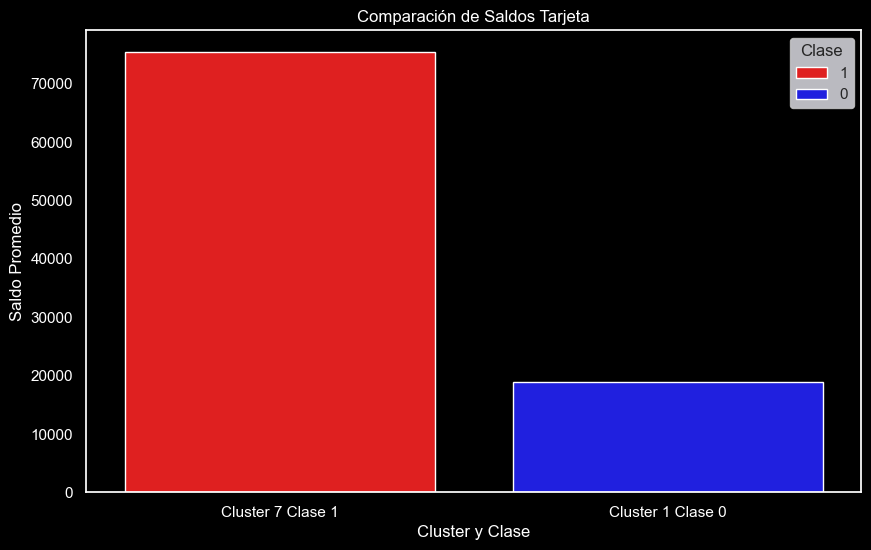

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df_cluster_7_class_1 = df_clustered[(df_clustered['cluster'] == 7) & (df_clustered['class_label'] == 1)]
df_cluster_1_class_0 = df_clustered[(df_clustered['cluster'] == 1) & (df_clustered['class_label'] == 0)]
mean_saldo_cluster_7_class_1 = df_cluster_7_class_1['t_saldo_total'].mean()
mean_saldo_cluster_1_class_0 = df_cluster_1_class_0['t_saldo_total'].mean()


data = {
    'Cluster y Clase': ['Cluster 7 Clase 1', 'Cluster 1 Clase 0'],
    'Saldo Promedio': [mean_saldo_cluster_7_class_1, mean_saldo_cluster_1_class_0],
    'Clase': ['1', '0']  # Añadir una columna para la clase
}
df_plot = pd.DataFrame(data)


sns.set(style="dark")


plt.figure(figsize=(10, 6))


ax = sns.barplot(
    x='Cluster y Clase', 
    y='Saldo Promedio', 
    data=df_plot,
    palette={'1': 'red', '0': 'blue'},  # Asignar colores a las clases
    hue='Clase'  # Usar la columna 'Clase' para asignar los colores
)

# Ajustar el color de las etiquetas y el título
ax.set_title('Comparación de Saldos Tarjeta', color='white')
ax.set_xlabel('Cluster y Clase', color='white')
ax.set_ylabel('Saldo Promedio', color='white')
ax.tick_params(colors='white')

# Cambiar el color del fondo de la figura y del eje
ax.set_facecolor('black')
plt.gcf().set_facecolor('black')

# Mostrar el gráfico
plt.show()

In [168]:
df_cluster_7 = df_clustered[df_clustered['cluster'] == 7]
df_cluster_7.groupby('Visa_status').agg(Visa_status = ('Visa_status', 'count'), Master_delinquency = ('Master_delinquency', 'mean')).style.background_gradient(cmap='Blues')

In [169]:
df_cluster_8 = df_clustered[df_clustered['cluster'] == 8]
df_cluster_8.groupby('Visa_status').agg(Visa_status = ('Visa_status', 'count'), Master_delinquency = ('Master_delinquency', 'mean')).style.background_gradient(cmap='Blues')

In [170]:
df_cluster_9 = df_clustered[df_clustered['cluster'] == 9]
df_cluster_9.groupby('Visa_status').agg(Visa_status = ('Visa_status', 'count'), Master_delinquency = ('Master_delinquency', 'mean')).style.background_gradient(cmap='Blues')

##### Cluster 9

## Modelo

In [178]:
# optuna.visualization.plot_optimization_history(study)

In [161]:
# plot_slice(study)

In [162]:
# plot_contour(study)

In [163]:
# plot_contour(study, params=["max_depth", "max_leaf_nodes"])

<!-- ### Variables más importantes -->

<Axes: >

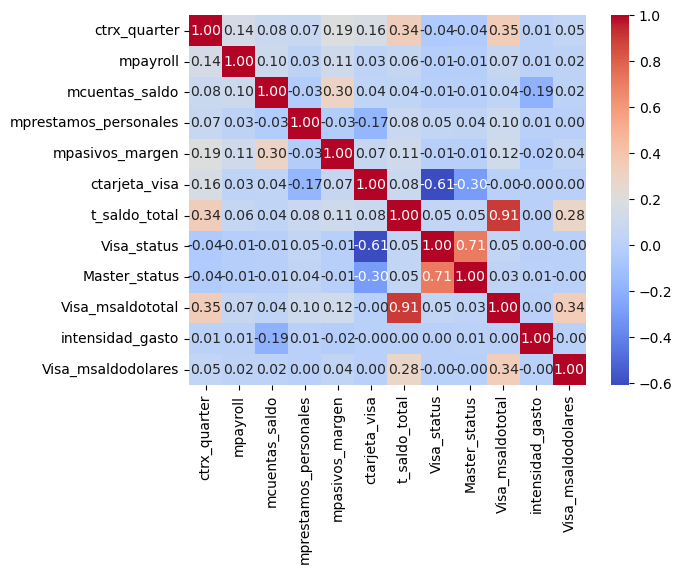

In [46]:
# # Analisis de la correlación de Pearson de estas variables

# df_train_abril = df_train[df_train['foto_mes'] == 202104]
# df_train_abril = df_train.drop(columns=['clase_ternaria'])  
# matriz_correlacion_abril = df_train_abril.corr()
# matriz_correlacion_abril = matriz_correlacion_abril.loc[lista_variables_utiles, lista_variables_utiles]
# sns.heatmap(matriz_correlacion_abril, annot=True, cmap='coolwarm', fmt=".2f")